In [1]:
%matplotlib inline
import os
os.environ['PY3_PROD'] = '1'
%load_ext autoreload
%autoreload 2
os.system('kinit')

1

In [2]:
import numpy as np
import pandas as pd
from typing import Union, List
import datetime
from pycmqlib3.utility import misc
from pycmqlib3.utility import dbaccess
from pycmqlib3.utility.dataseries import *
from pycmqlib3.analytics.tstool import *
from pycmqlib3.analytics.btmetrics import *
from pathlib import Path
import json
import akshare as ak

#pd.set_option('display.max_rows', 100)
#pd.set_option('display.max_columns', 100)
#pd.set_option('display.width', 1000)

In [3]:
dbaccess.update_contract_list_table(datetime.date(2023,1,16))
# misc.update_holidays_from_aks(outfile='holidays.json')

In [3]:
ferrous_products_mkts = ['rb', 'hc', 'i', 'j', 'jm']
ferrous_mixed_mkts = ['ru', 'FG', 'ZC', 'SM', "SF", 'nr']
base_metal_mkts = ['cu', 'al', 'zn', 'pb', 'ni', 'sn', 'ss']
precious_metal_mkts = ['au', 'ag']
ind_metal_mkts = ferrous_products_mkts + ferrous_mixed_mkts + base_metal_mkts
petro_chem_mkts = ['l', 'pp', 'v', 'TA', 'MA', 'bu', 'sc', 'fu', 'eg', 'eb', 'lu', 'pg', 'PF']
ind_all_mkts = ind_metal_mkts + petro_chem_mkts
ags_oil_mkts = ['m', 'RM', 'y', 'p', 'OI', 'a', 'c', 'cs', 'b'] #, 'b']
ags_soft_mkts = ['CF', 'SR', 'jd', 'AP', 'sp', 'CJ', 'UR', 'SA', 'lh', 'PK', 'CY',] # ]
ags_all_mkts = ags_oil_mkts + ags_soft_mkts
eq_fut_mkts = ['IF', 'IH', 'IC', 'IM',]
bond_fut_mkts = ['T', 'TF', 'TS']
fin_all_mkts = eq_fut_mkts + bond_fut_mkts
commod_all_mkts = ind_all_mkts + ags_all_mkts + precious_metal_mkts
all_markets = commod_all_mkts + fin_all_mkts


In [5]:
product_start_dict = {
    'c': datetime.date(2010,1,1), 
    'm': datetime.date(2010,1,1),
    'y': datetime.date(2010,1,1), 
    'l': datetime.date(2010,1,1), 
    'rb':datetime.date(2010,1,1),
    'p': datetime.date(2010,1,1), 
    'cu':datetime.date(2010,1,1), 
    'al':datetime.date(2010,1,1),
    'zn':datetime.date(2010,1,1), 
    'au':datetime.date(2015,12,1), 
    'v': datetime.date(2010,1,1),
    'a': datetime.date(2010,1,1), 
    'ru':datetime.date(2011,1,1), 
    'ag':datetime.date(2012,6,1),
    'i': datetime.date(2014,1,1), 
    'j': datetime.date(2012,6,1), 
    'jm':datetime.date(2013,7,1),
    'CF':datetime.date(2012,5,1),  
    'TA':datetime.date(2012,4,15),
    'PM':datetime.date(2013,10,1), 
    'RM':datetime.date(2013,1,1),  
    'SR':datetime.date(2013,1,1),
    'FG':datetime.date(2013,1,1),  
    'OI':datetime.date(2013,5,1),  
    'RI':datetime.date(2013,1,1),
    'WH':datetime.date(2014,5,1),  
    'pp':datetime.date(2014,5,1),
    'IF':datetime.date(2010,5,1),  
    'MA':datetime.date(2012,1,1),  
    'TF':datetime.date(2013,9,9),
    'IH':datetime.date(2015,5,1),  
    'IC':datetime.date(2015,5,1),  
    'cs':datetime.date(2015,2,1),
    'jd':datetime.date(2014,5,1),  
    'ni':datetime.date(2015,9,1),  
    'sn':datetime.date(2017,5,1),
    'ZC':datetime.date(2013,11,1), 
    'hc':datetime.date(2016, 4, 1), 
    'SM': datetime.date(2017,1,1),
    'SF': datetime.date(2017,9,1), 
    'CY': datetime.date(2017, 9, 1), 
    'AP': datetime.date(2018, 1, 1),
    'TS': datetime.date(2018, 9, 1), 
    'fu': datetime.date(2018, 9, 1), 
    'sc': datetime.date(2018, 10, 1),
    'b': datetime.date(2019, 9, 1), 
    'pb': datetime.date(2016, 7, 1), 
    'bu': datetime.date(2015, 9, 15),
    'T':datetime.date(2019,4,1), 
    'ss': datetime.date(2020, 5, 1), 
    'sp': datetime.date(2019, 5, 1),
    'CJ': datetime.date(2019, 8, 9), 
    'UR': datetime.date(2019, 8, 9), 
    'SA': datetime.date(2020, 1, 1),
    'eb': datetime.date(2020, 2, 1), 
    'eg': datetime.date(2019, 4, 2), 
    'rr': datetime.date(2019, 9, 1),
    'pg': datetime.date(2020, 3, 30), 
    'lu': datetime.date(2020, 6, 22), 
    'nr': datetime.date(2020,1,1),
    'lh': datetime.date(2021,5,1), 
    'PF': datetime.date(2021,1,1), 
    'PK': datetime.date(2021,4,1), 
}


# Implement testing for update_contract_roll

In [13]:
def update_expiry_roll(start_date=datetime.date(2020, 1, 1),
                       end_date=datetime.date.today(),
                       cutoff=misc.day_shift(datetime.date.today(), '-1b', misc.CHN_Holidays),
                       roll_name='troll',
                       folder="C:/dev/wtdev/config/roll",
                       markets=all_markets,
                       skip_exists=True):
    roll_mode = 0
    roll_win = 1
    cont_thres = 0
    cont_ratio = [1.0, 1.0]
    product_starts = {
        'fu': datetime.date(2018, 9, 1),
        'b': datetime.date(2018, 1, 3),
        'nr': datetime.date(2020, 2, 1),
        'pb': datetime.date(2013, 12, 1),
    }
    contract_filter = main_cont_filter
    res = {}
    for prodcode in markets:
        sdate = start_date
        exch = misc.prod2exch(prodcode)
        nb_cont = 2
        roll_cutoff = '-30b'
        if prodcode in ['cu', 'al', 'zn', 'pb', 'sn', 'ss', 'sp', ]:
            roll_cutoff = '-25b'
        elif prodcode in ['ni', 'jd', 'lh', ]:
            roll_cutoff = '-35b'
        elif prodcode in ['sc', 'eb'] + bond_fut_mkts:
            roll_cutoff = '-20b'
        elif prodcode in ['lu']:
            roll_cutoff = '-45b'
        elif prodcode in precious_metal_mkts:
            roll_cutoff = '-15b'
        elif prodcode in eq_fut_mkts:
            roll_cutoff = '-0b'
        if prodcode in product_starts:
            sdate = max(sdate, product_starts[prodcode])
        if prodcode in ['cu', 'al', 'zn', 'ss', ]:
            nb_cont = 3
        filename = "%s/%s_%s.csv" % (folder, prodcode, roll_name)
        file = Path(filename)
        if file.exists():
            if skip_exists:
                continue
            curr_roll = pd.read_csv(file, parse_dates=['date'])
            curr_roll['date'] = curr_roll['date'].dt.date
            curr_roll = curr_roll[
                [col for col in curr_roll.columns if col in ['date'] + [str(i) for i in range(nb_cont)]]]
            curr_roll = curr_roll[curr_roll['date'] < cutoff]
            curr_roll = curr_roll.set_index('date')
        else:
            curr_roll = pd.DataFrame(columns=[str(i) for i in range(nb_cont)])
            curr_roll.index.name = 'date'
        roll_kwargs = {'roll_win': roll_win, 'roll_cutoff': roll_cutoff, 'cont_ratio': cont_ratio,
                       'contract_filter': contract_filter, 'min_thres': 0}
        df = load_processed_fut_by_product(prodcode,
                                           start_date=sdate,
                                           end_date=end_date,
                                           freq='d',
                                           **roll_kwargs)
        roll_map, daily_cont = rolling_fut_cont(df, nb_cont=nb_cont,
                                                cont_thres=cont_thres,
                                                roll_mode=roll_mode,
                                                curr_roll=curr_roll)
        if len(roll_map) == 0:
            print(f"empty roll map, skipping {prodcode}\n")
            continue
        for idx in range(1, nb_cont):
            if roll_map[str(idx)].iloc[-1] is None:
                roll_map[str(idx)].iloc[-1] = misc.default_next_main_contract(roll_map[str(idx - 1)].iloc[-1],
                                                                              start_date, end_date)
        #         flag = roll_map['1'].isna()
        #         roll_map['1'].loc[flag] = roll_map['0'].loc[flag.shift(1).fillna(False)].values
        #         roll_map = roll_map.set_index('date')
        roll_map.to_csv(filename)
        res[prodcode] = roll_map
    return res


In [19]:
start_date=datetime.date(2020, 1, 1)
end_date=datetime.date(2022, 12, 21)
cutoff=misc.day_shift(datetime.date.today(), '-1b', misc.CHN_Holidays)
roll_name='vroll'
folder="C:/dev/wtdev/config/roll"
markets = ['rb']
roll_mode = 0
cont_thres = 1e+6
skip_exists=True
cont_ratio=[1.0, 0.0]
min_thres=7500
roll_win = 1
product_starts = {
    'fu': datetime.date(2018, 9, 1),
    'b': datetime.date(2018, 1, 3),
    'nr': datetime.date(2020, 2, 1),
    'pb': datetime.date(2013, 12, 1),
}
res = {}
prodcode = 'rb'
roll_cutoff = '-20b'
nb_cont = 2
sdate = start_date
contract_filter = None
if prodcode in ['IF', 'IC', 'IH', 'IM', 'sc', ]:
    min_thres = 0.1 * min_thres
elif prodcode in ['j', 'ni', 'sn', 'cu', 'bc', 'lh']:
    min_thres = 0.2 * min_thres
elif prodcode in ['ru', 'nr', 'al', 'zn', 'pb', 'jm', 'ss', 'PK', 'b', ]:
    min_thres = 0.5 * min_thres
elif prodcode in ['SM', 'SF', 'FG', 'i', 'AP', 'eb', ]:
    min_thres = 0.8 * min_thres
elif prodcode in ['T', 'TF', 'TS']:
    min_thres = 0
if prodcode in ['IF', 'IC', 'IH', 'IM', ]:
    roll_cutoff = '0b'
if prodcode in product_starts:
    sdate = max(sdate, product_starts[prodcode])
if prodcode in ['cu', 'al', 'zn', 'ss',]:
    nb_cont = 3
# filename = "%s/%s_%s.csv" % (folder, prodcode, roll_name)
# file = Path(filename)
# if file.exists():
#     if skip_exists:
#         continue
#     curr_roll = pd.read_csv(file, parse_dates=['date'])
#     curr_roll['date'] = curr_roll['date'].dt.date
#     curr_roll = curr_roll[[col for col in curr_roll.columns if col in ['date'] + [str(i) for i in range(nb_cont)]]]
#     curr_roll = curr_roll[curr_roll['date'] < cutoff]
# else:
curr_roll = pd.DataFrame(columns = [str(i) for i in range(nb_cont)])
curr_roll.index.name = 'date'
roll_kwargs = {'roll_win': roll_win, 'roll_cutoff': roll_cutoff, 'cont_ratio': cont_ratio,
               'contract_filter': contract_filter, 'min_thres': min_thres}
df = load_processed_fut_by_product(prodcode,
                                   start_date=sdate,
                                   end_date=end_date,
                                   freq='d',
                                   **roll_kwargs)
df
# roll_map, daily_cont = rolling_fut_cont(df, nb_cont=nb_cont, 
#                                         cont_thres=cont_thres, 
#                                         roll_mode=roll_mode,
#                                         curr_roll=curr_roll)



,instID,date,open,high,low,close,volume,openInterest,diff_oi,expiry,exp_str,month,roll_date,roll_ind,log_ret,price_chg
147,rb2005,2020-01-02,3584.0,3593.0,3540.0,3547.0,976947.0,1443715.0,-1504643.0,2020-05-15,2020-05-15,5,2020-04-14,976947.0,0.000000,0.0
148,rb2005,2020-01-03,3547.0,3567.0,3542.0,3543.0,778292.0,1398669.0,-45046.0,2020-05-15,2020-05-15,5,2020-04-14,778292.0,-0.001128,-4.0
149,rb2005,2020-01-06,3540.0,3566.0,3526.0,3559.0,966449.0,1381265.0,-17404.0,2020-05-15,2020-05-15,5,2020-04-14,966449.0,0.004506,16.0
150,rb2005,2020-01-07,3558.0,3580.0,3556.0,3574.0,708368.0,1400763.0,19498.0,2020-05-15,2020-05-15,5,2020-04-14,708368.0,0.004206,15.0
151,rb2005,2020-01-08,3574.0,3621.0,3571.0,3617.0,1051293.0,1419374.0,18611.0,2020-05-15,2020-05-15,5,2020-04-14,1051293.0,0.011960,43.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8509,rb2310,2022-12-19,4022.0,4026.0,3902.0,3910.0,77240.0,266724.0,-1584.0,2023-10-16,2023-10-16,10,2023-09-18,77240.0,-0.031964,-127.0
8510,rb2310,2022-12-20,3900.0,3950.0,3885.0,3922.0,36560.0,268160.0,1436.0,2023-10-16,2023-10-16,10,2023-09-18,36560.0,0.003064,12.0
8511,rb2310,2022-12-21,3954.0,4020.0,3912.0,4016.0,43707.0,270477.0,2317.0,2023-10-16,2023-10-16,10,2023-09-18,43707.0,0.023685,94.0
8536,rb2311,2022-12-20,3890.0,3931.0,3888.0,3910.0,10060.0,11897.0,10016.0,2023-11-15,2023-11-15,11,2023-10-18,10060.0,0.005128,20.0


In [21]:
inst_list = df['instID'].unique()
expiry_map = dict([(inst, misc.contract_expiry(inst, hols=misc.CHN_Holidays)) for inst in inst_list])
expiry_inv_map = {str(v): k for k, v in expiry_map.items()}
roll_df = pd.pivot_table(df, index=['date'], columns='expiry', values='roll_ind', aggfunc='first')
inst_df = pd.pivot_table(df, index=['date'], columns='expiry', values='exp_str', aggfunc='first')
daily_index = roll_df.index
curr_list = []
data_list = []
date_list = []
print(inst_df)

expiry      2020-05-15 2020-09-15  2020-10-15 2021-01-15 2021-02-18  \
date                                                                  
2020-01-02  2020-05-15        NaN  2020-10-15        NaN        NaN   
2020-01-03  2020-05-15        NaN  2020-10-15        NaN        NaN   
2020-01-06  2020-05-15        NaN  2020-10-15        NaN        NaN   
2020-01-07  2020-05-15        NaN  2020-10-15        NaN        NaN   
2020-01-08  2020-05-15        NaN  2020-10-15        NaN        NaN   
...                ...        ...         ...        ...        ...   
2022-12-15         NaN        NaN         NaN        NaN        NaN   
2022-12-16         NaN        NaN         NaN        NaN        NaN   
2022-12-19         NaN        NaN         NaN        NaN        NaN   
2022-12-20         NaN        NaN         NaN        NaN        NaN   
2022-12-21         NaN        NaN         NaN        NaN        NaN   

expiry     2021-03-15 2021-04-15 2021-05-17 2021-06-15 2021-07-15  ...  \
da

# dealing with rolling json and excel file conversion

In [3]:
from pycmqlib3.utility.process_wt_data import *
from misc_scripts.update_contract_roll import *


In [56]:
# "C:/dev/wtdev/config/roll_main_hot.xlsx",

write_roll_json_to_excel("C:/dev/wtdev/config/expiry.xlsx",
                         roll_files=['C:/dev/wtdev/config/expiry1.json', 'C:/dev/wtdev/config/expiry2.json'],
                         roll_names=['expiry1', 'expiry2'])


In [54]:
excel_file = "C:/dev/wtdev/config/troll.xlsx"
# "C:/dev/wtdev/config/roll_main_hot.xlsx"
# "C:/dev/wtdev/config/troll.xlsx"
roll_dict = read_roll_list_from_excel(excel_file)
roll_dict.keys()

dict_keys(['troll1', 'troll2'])

In [ ]:
name_map = {
    "hots": "main1",
    "seconds": "main2",
    "troll1": "expiry1",
    "troll2": "expiry2",
}

folder = 'C:/dev/wtdev/config/'
for key in roll_dict:
    roll_name = name_map.get(key, key)
    fname = f"{folder}{roll_name}.json"
    with open(fname, 'w') as ofile:
        json.dump(roll_dict[key], ofile, indent=4)

In [138]:
output = update_expiry_roll(
        start_date=datetime.date(2020, 1, 1),
        end_date=datetime.date.today(),
        cutoff=misc.day_shift(datetime.date.today(), '-1b', misc.CHN_Holidays),
        roll_name='expiry',
        folder="C:/dev/wtdev/config",
        skip_exists=False
)


In [139]:
output['addon']

[{'date': datetime.date(2022, 8, 22), '0': 'ZC301', '1': 'nan'},
 {'date': datetime.date(2022, 10, 25), '0': 'ZC305', '1': 'ZC309'},
 {'date': datetime.date(2022, 12, 28), '0': 'nr2303', '1': 'nr2304'},
 {'date': datetime.date(2023, 1, 5), '0': 'cu2303', '1': 'cu2304'},
 {'date': datetime.date(2023, 1, 5), '0': 'al2303', '1': 'al2304'},
 {'date': datetime.date(2023, 1, 5), '0': 'zn2303', '1': 'zn2304'},
 {'date': datetime.date(2023, 1, 5), '0': 'pb2303', '1': 'pb2304'},
 {'date': datetime.date(2022, 12, 21), '0': 'ni2303', '1': 'ni2304'},
 {'date': datetime.date(2023, 1, 19), '0': 'ni2304', '1': 'ni2305'},
 {'date': datetime.date(2023, 1, 5), '0': 'sn2303', '1': 'sn2304'},
 {'date': datetime.date(2023, 1, 5), '0': 'ss2303', '1': 'ss2304'},
 {'date': datetime.date(2021, 7, 13), '0': 'bc2109', '1': 'bc2110'},
 {'date': datetime.date(2021, 8, 12), '0': 'bc2110', '1': 'bc2111'},
 {'date': datetime.date(2021, 9, 2), '0': 'bc2111', '1': 'bc2112'},
 {'date': datetime.date(2021, 10, 12), '0': 

In [141]:
curr_date=datetime.date(2023,1,20)
new_updates = output['addon']
if len(new_updates) > 0:
    sub = '合约换月邮件<%s>' % (curr_date.strftime('%Y.%m.%d'))
    content = ''
    for data in new_updates:
        content += '交易日(%s) expiry roll contract nb1: %s  nb2: %s\n' % (data["date"].strftime('%Y.%m.%d'),
                                                                        data["0"], data["1"])
content


'交易日(2022.08.22) expiry roll contract nb1: ZC301  nb2: nan\n交易日(2022.10.25) expiry roll contract nb1: ZC305  nb2: ZC309\n交易日(2022.12.28) expiry roll contract nb1: nr2303  nb2: nr2304\n交易日(2023.01.05) expiry roll contract nb1: cu2303  nb2: cu2304\n交易日(2023.01.05) expiry roll contract nb1: al2303  nb2: al2304\n交易日(2023.01.05) expiry roll contract nb1: zn2303  nb2: zn2304\n交易日(2023.01.05) expiry roll contract nb1: pb2303  nb2: pb2304\n交易日(2022.12.21) expiry roll contract nb1: ni2303  nb2: ni2304\n交易日(2023.01.19) expiry roll contract nb1: ni2304  nb2: ni2305\n交易日(2023.01.05) expiry roll contract nb1: sn2303  nb2: sn2304\n交易日(2023.01.05) expiry roll contract nb1: ss2303  nb2: ss2304\n交易日(2021.07.13) expiry roll contract nb1: bc2109  nb2: bc2110\n交易日(2021.08.12) expiry roll contract nb1: bc2110  nb2: bc2111\n交易日(2021.09.02) expiry roll contract nb1: bc2111  nb2: bc2112\n交易日(2021.10.12) expiry roll contract nb1: bc2112  nb2: bc2201\n交易日(2021.11.11) expiry roll contract nb1: bc2201  nb2: bc220

In [50]:
from wtpy.apps import WtHotPicker, WtCacheMonExchg, WtCacheMonSS
end_date=None
files={'loc': 'C:/dev/wtdev/config/', 
       'hot': 'main1.json', 
       'sec': 'main2.json', 
       'marker': 'marker.json'}
snapshot_loc="C:/dev/wtdev/storage/his/snapshot/",
cacher = WtCacheMonSS(snapshot_loc)

picker = WtHotPicker(files)
picker.set_cacher(cacher)
picker.execute_increment(end_date)

CFFEX {}
SHFE {}
CZCE {}
DCE {}
INE {}
GFEX {}


In [48]:
import logging

logging.basicConfig(filename='hotsel.log', level=logging.INFO, filemode="w",
    format='[%(asctime)s - %(levelname)s] %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S')

console = logging.StreamHandler()
console.setLevel(logging.INFO)
# 设置日志打印格式
formatter = logging.Formatter(fmt="[%(asctime)s - %(levelname)s] %(message)s", datefmt='%m-%d %H:%M:%S')
console.setFormatter(formatter)
# 将定义好的console日志handler添加到root logger
logging.getLogger('').addHandler(console)

In [98]:
folder = 'C:/dev/wtdev/config/roll'
roll_name = 'vroll'
prodcode = 'rb'
nb_cont = 2


    
exch = misc.prod2exch(prodcode)
filename = "%s/%s_%s.csv" % (folder, prodcode, roll_name)
curr_roll = pd.read_csv(filename, parse_dates=['date'])
curr_roll['date'] = curr_roll['date'].dt.date
curr_roll = curr_roll.set_index('date')

                worksheet.write(0, start_col, roll_name + '.' + prodcode)
                worksheet.write(0, start_col + 1, roll_name + '.' + prodcode)
                roll_map = roll_list_to_df(roll_dict[roll_name][exch][prodcode])
                roll_map.to_excel(writer, sheet_name=exch, startcol=start_col, startrow=1)


,date,0,1
0,2009-03-27,rb0909,NaN
1,2009-08-05,rb0910,rb0911
2,2009-09-02,rb0911,rb0912
3,2009-09-30,rb0912,rb1001
4,2009-11-06,rb1001,rb1002
5,2009-12-07,rb1002,rb1003
6,2010-01-06,rb1003,rb1005
7,2010-01-11,rb1005,rb1010
8,2010-04-19,rb1010,rb1101
9,2010-08-26,rb1101,rb1105


In [103]:
curr_roll[curr_roll['1'] != curr_roll['1'].shift(1)]

,date,0,1


In [107]:
folder = 'C:/dev/wtdev/config/roll'
roll_name = 'oroll'

exchanges = ['DCE', "CZCE", 'SHFE', 'INE', 'CFFEX', 'GFEX']
roll_res = dict([(exch, {}) for exch in exchanges])
for prodcode in all_markets:
    exch = misc.prod2exch(prodcode)
    filename = "%s/%s_%s.csv" % (folder, prodcode, roll_name)
    curr_roll = pd.read_csv(filename, parse_dates=['date'])
    curr_roll['date'] = curr_roll['date'].dt.date
    curr_roll = curr_roll[[col for col in curr_roll.columns if col in ['date'] + [str(i) for i in range(nb_cont)]]]
    curr_roll = curr_roll.set_index('date')
    roll_res[exch][prodcode] = curr_roll

    
out_excel = f'{folder}/{roll_name}.xlsx'
writer = pd.ExcelWriter(out_excel, engine='xlsxwriter')
workbook = writer.book

for exch in exchanges:
    worksheet = workbook.add_worksheet(exch)
    writer.sheets[exch] = worksheet
    start_col = 0
    for prodcode in sorted(roll_res[exch].keys()):
        for key in roll_res[exch][prodcode].columns:
            roll_map = roll_res[exch][prodcode][[key]].rename(columns={key: 'instID'})
            worksheet.write(0, start_col, roll_name + str(int(key)+1) + '.' + prodcode)
            worksheet.write(0, start_col + 1, roll_name + str(int(key)+1) + '.' + prodcode)
            roll_map.to_excel(writer, sheet_name=exch, startcol=start_col, startrow=1)
            start_col +=3
writer.close()


In [ ]:
from pycmqlib3.utility.process_wt_data import *

In [93]:
df = nearby('IC', 
            start_date=datetime.date(2019,10,30),
            end_date=datetime.date(2020,1,5), 
            freq='m', 
            shift_mode=1, 
            roll_name='hot', 
            config_loc='C:/dev/wtdev/config/')
df

,contract,datetime,date,min_id,open,high,low,close,volume,openInterest,diff_oi,shift
0,IC1911,2019-10-30 09:30:00,2019-10-30,1530,4907.0,4907.0,4890.8,4897.2,1347.0,66398.0,-860.0,-56.0
1,IC1911,2019-10-30 09:31:00,2019-10-30,1531,4897.4,4901.4,4895.0,4897.8,666.0,65928.0,-470.0,-56.0
2,IC1911,2019-10-30 09:32:00,2019-10-30,1532,4898.8,4901.6,4897.4,4900.8,535.0,65631.0,-297.0,-56.0
3,IC1911,2019-10-30 09:33:00,2019-10-30,1533,4900.8,4901.0,4895.0,4896.2,504.0,65272.0,-359.0,-56.0
4,IC1911,2019-10-30 09:34:00,2019-10-30,1534,4896.0,4896.0,4888.0,4889.6,832.0,64830.0,-442.0,-56.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2635,IC2001,2020-01-03 14:55:00,2020-01-03,2055,5374.0,5376.8,5372.2,5376.2,299.0,70358.0,67.0,0.0
2636,IC2001,2020-01-03 14:56:00,2020-01-03,2056,5376.0,5376.6,5374.6,5375.6,292.0,70511.0,153.0,0.0
2637,IC2001,2020-01-03 14:57:00,2020-01-03,2057,5375.8,5377.0,5375.4,5376.4,284.0,70611.0,100.0,0.0
2638,IC2001,2020-01-03 14:58:00,2020-01-03,2058,5376.2,5377.2,5376.2,5376.6,358.0,70740.0,129.0,0.0


# WtDtServo and DataHelper data checking

In [4]:
from wtpy.wrapper import WtDataHelper
from wtpy import WtDtServo

In [5]:
folder_loc='C:/dev/wtdev/storage/his'
period='day'
exch = 'SHFE'
file = 'rb2305.dsb'
dtHelper = WtDataHelper()

src_path = '%s/%s/%s' % (folder_loc, period, exch)
dst_df = dtHelper.read_dsb_bars(f'{src_path}/{file}')
ddf = dst_df.to_df()
ddf

,date,bartime,open,high,low,close,settle,money,volume,hold,diff
199000000000,20220517,199000000000,4410.0,4520.0,4410.0,4484.0,4488.0,1.515598e+08,3377.0,1889.0,0.0
199000000000,20220518,199000000000,4480.0,4520.0,4398.0,4398.0,4440.0,1.693860e+08,3815.0,4590.0,2701.0
199000000000,20220519,199000000000,4400.0,4428.0,4336.0,4417.0,4368.0,1.747637e+08,4001.0,5613.0,1023.0
199000000000,20220520,199000000000,4429.0,4480.0,4401.0,4465.0,4452.0,1.272827e+08,2859.0,6638.0,1025.0
199000000000,20220523,199000000000,4463.0,4517.0,4406.0,4442.0,4463.0,9.939101e+07,2227.0,6904.0,266.0
...,...,...,...,...,...,...,...,...,...,...,...
199000000000,20230109,199000000000,4105.0,4140.0,4072.0,4093.0,4100.0,6.592263e+10,1607579.0,1863784.0,-60166.0
199000000000,20230110,199000000000,4103.0,4136.0,4087.0,4124.0,4109.0,4.451952e+10,1083219.0,1930856.0,67072.0
199000000000,20230111,199000000000,4120.0,4172.0,4101.0,4161.0,4136.0,4.600966e+10,1112383.0,1955990.0,25134.0
199000000000,20230112,199000000000,4152.0,4163.0,4091.0,4136.0,4126.0,5.439544e+10,1318042.0,1867251.0,-88739.0


In [6]:
dtServo = WtDtServo()
folder_loc='C:/dev/wtdev'
dtServo.setBasefiles(folder=f"{folder_loc}/common/")
dtServo.setStorage(path=f'{folder_loc}/storage/')
df = dtServo.get_bars('SHFE.rb.2305', period='d1', fromTime=202301022100, endTime=202301142200)

In [7]:
df.to_df()

,date,bartime,open,high,low,close,settle,money,volume,hold,diff
0,20230103,0,4100.0,4100.0,4016.0,4063.0,4044.0,5.039089e+10,1245821.0,1882723.0,-49122.0
0,20230104,0,4061.0,4084.0,4010.0,4027.0,4045.0,5.594287e+10,1383006.0,1874643.0,-8080.0
0,20230105,0,4015.0,4024.0,3970.0,4017.0,4001.0,6.091715e+10,1522301.0,1825776.0,-48867.0
0,20230106,0,4031.0,4122.0,4023.0,4107.0,4070.0,7.044603e+10,1730447.0,1923950.0,98174.0
0,20230109,0,4105.0,4140.0,4072.0,4093.0,4100.0,6.592263e+10,1607579.0,1863784.0,-60166.0
0,20230110,0,4103.0,4136.0,4087.0,4124.0,4109.0,4.451952e+10,1083219.0,1930856.0,67072.0
0,20230111,0,4120.0,4172.0,4101.0,4161.0,4136.0,4.600966e+10,1112383.0,1955990.0,25134.0
0,20230112,0,4152.0,4163.0,4091.0,4136.0,4126.0,5.439544e+10,1318042.0,1867251.0,-88739.0
0,20230113,0,4131.0,4186.0,4113.0,4173.0,4154.0,5.310272e+10,1278231.0,1927798.0,60547.0


In [79]:
i=0
for alist, blist in zip(inst_df.reset_index().to_numpy(), roll_df.reset_index().to_numpy()):
    if i==1:
        run_date = alist[0]
        cont_list = alist[1:]
        ind_list = blist[1:]
        print(run_date, cont_list, ind_list)
        flag = np.array([(cont > '2020-05-15') and (ind>0) for cont, ind in zip(cont_list, ind_list)])
        print(flag)
        break
    i += 1

2020-01-03 ['2020-05-15' '2020-10-15' '' '' '' '' ''] [778292.0 45834.0 0.0 0.0 0.0 0.0 0.0]
[False  True False False False False False]


In [ ]:
start_date = datetime.date(2007, 1, 1)
end_date = datetime.date(2022,12,16)
folder = 'C:/dev/wtdev/config/roll'

roll_map = pd.read_csv('C:/dev/wtdev/config/roll/au_troll.csv', parse_dates=['date'])
roll_map['date'] = roll_map['date'].dt.date

In [57]:
res = update_expiry_roll(start_date=datetime.date(2007,1,1),
                   end_date=end_date,
                   cutoff=misc.day_shift(end_date, '-1b', misc.CHN_Holidays),
                   roll_name='troll',
                   folder=folder, 
                   markets=all_markets,
                   skip_exists=False)


                 0       1
date                      
2009-03-27  rb0910  rb1001
2009-08-27  rb1001  rb1005
2009-12-04  rb1005  rb1010
2010-04-02  rb1010  rb1101
2010-08-25  rb1101  rb1105
2010-12-06  rb1105  rb1110
2011-03-31  rb1110  rb1201
2011-08-29  rb1201  rb1205
2011-12-02  rb1205  rb1210
2012-03-28  rb1210  rb1301
2012-08-28  rb1301  rb1305
2012-11-30  rb1305  rb1310
2013-03-28  rb1310  rb1401
2013-08-26  rb1401  rb1405
2013-12-02  rb1405  rb1410
2014-04-01  rb1410  rb1501
2014-08-27  rb1501  rb1505
2014-12-03  rb1505  rb1510
2015-04-02  rb1510  rb1601
2015-08-26  rb1601  rb1605
2015-12-04  rb1605  rb1610
2016-04-01  rb1610  rb1701
2016-08-26  rb1701  rb1705
2016-12-05  rb1705  rb1710
2017-03-30  rb1710  rb1801
2017-08-29  rb1801  rb1805
2017-12-04  rb1805  rb1810
2018-03-29  rb1810  rb1901
2018-08-27  rb1901  rb1905
2018-12-03  rb1905  rb1910
2019-03-29  rb1910  rb2001
2019-08-27  rb2001  rb2005
2019-12-04  rb2005  rb2010
2020-03-31  rb2010  rb2101
2020-08-27  rb2101  rb2105
2

                0      1
date                    
2014-08-08  SF501  SF505
2014-12-04  SF505    nan
2014-12-08  SF509    nan
2015-07-31  SF601    nan
2015-12-04  SF605    nan
2016-04-01  SF609    nan
2016-04-08  SF701    nan
2016-07-08  SF705    nan
2017-03-30  SF709  SF801
2017-08-04  SF801    nan
2017-12-04  SF805  SF809
2018-03-29  SF809  SF901
2018-08-06  SF901  SF905
2018-12-03  SF905  SF909
2019-04-02  SF909  SF001
2019-08-05  SF001  SF005
2019-12-04  SF005  SF009
2020-04-02  SF009  SF101
2020-08-04  SF101  SF105
2020-12-04  SF105  SF109
2021-04-02  SF109  SF201
2021-08-04  SF201  SF205
2021-12-06  SF205  SF209
2022-03-31  SF209  SF301
2022-08-04  SF301  SF305
2022-12-05  SF305  SF309
                 0       1
date                      
2020-02-03  nr2003  nr2004
2020-02-04  nr2004  nr2005
2020-03-04  nr2005  nr2006
2020-03-31  nr2006  nr2007
2020-04-30  nr2007  nr2008
2020-06-02  nr2008  nr2009
2020-07-07  nr2009  nr2010
2020-08-05  nr2010  nr2011
2020-08-27  nr2011  nr2012
202

                 0       1
date                      
2014-02-28  pp1405  pp1409
2014-04-02  pp1409  pp1501
2014-08-04  pp1501  pp1505
2014-12-04  pp1505  pp1509
2015-04-02  pp1509  pp1601
2015-08-04  pp1601  pp1605
2015-12-04  pp1605  pp1609
2016-04-01  pp1609  pp1701
2016-08-04  pp1701  pp1705
2016-12-05  pp1705  pp1709
2017-03-30  pp1709  pp1801
2017-08-04  pp1801  pp1805
2017-12-04  pp1805  pp1809
2018-03-29  pp1809  pp1901
2018-08-06  pp1901  pp1905
2018-12-03  pp1905  pp1909
2019-04-02  pp1909  pp2001
2019-08-05  pp2001  pp2005
2019-12-04  pp2005  pp2009
2020-04-02  pp2009  pp2101
2020-08-04  pp2101  pp2105
2020-12-04  pp2105  pp2109
2021-04-02  pp2109  pp2201
2021-08-04  pp2201  pp2205
2021-12-06  pp2205  pp2209
2022-03-31  pp2209  pp2301
2022-08-04  pp2301  pp2305
2022-12-05  pp2305  pp2309
                0      1
date                    
2009-05-25  v0909  v1001
2009-08-04  v1001  v1005
2009-12-04  v1005  v1009
2010-04-02  v1009  v1101
2010-08-04  v1101  v1105
2010-12-06  v11

                 0       1
date                      
2020-06-22  lu2101  lu2102
2020-10-30  lu2102  lu2103
2020-11-27  lu2103  lu2104
2020-12-18  lu2104  lu2105
2021-01-21  lu2105  lu2106
2021-02-26  lu2106  lu2107
2021-03-24  lu2107  lu2108
2021-04-23  lu2108  lu2109
2021-05-28  lu2109  lu2110
2021-06-30  lu2110  lu2111
2021-07-28  lu2111  lu2112
2021-08-19  lu2112  lu2201
2021-09-22  lu2201  lu2202
2021-11-01  lu2202  lu2203
2021-11-26  lu2203  lu2204
2021-12-20  lu2204  lu2205
2022-01-21  lu2205  lu2206
2022-02-24  lu2206  lu2207
2022-03-23  lu2207  lu2208
2022-04-25  lu2208  lu2209
2022-05-27  lu2209  lu2210
2022-06-30  lu2210  lu2211
2022-07-29  lu2211  lu2212
2022-08-22  lu2212  lu2301
2022-09-22  lu2301  lu2302
2022-10-31  lu2302  lu2303
2022-11-30  lu2303  lu2304
                 0       1
date                      
2020-03-30  pg2101     nan
2020-12-15  pg2105     nan
2021-04-12  pg2109  pg2201
2021-08-13  pg2201     nan
2021-12-14  pg2205  pg2209
2022-04-12  pg2209  pg2301
2

                 0       1
date                      
2014-12-19  cs1505  cs1509
2015-04-02  cs1509  cs1601
2015-08-04  cs1601  cs1605
2015-12-04  cs1605  cs1609
2016-04-01  cs1609  cs1701
2016-08-04  cs1701  cs1705
2016-12-05  cs1705  cs1709
2017-03-30  cs1709  cs1801
2017-08-04  cs1801  cs1805
2017-12-04  cs1805  cs1809
2018-03-29  cs1809  cs1901
2018-08-06  cs1901  cs1905
2018-12-03  cs1905  cs1909
2019-04-02  cs1909  cs2001
2019-08-05  cs2001  cs2005
2019-12-04  cs2005  cs2009
2020-04-02  cs2009  cs2101
2020-08-04  cs2101  cs2105
2020-12-04  cs2105  cs2109
2021-04-02  cs2109  cs2201
2021-08-04  cs2201  cs2205
2021-12-06  cs2205  cs2209
2022-03-31  cs2209  cs2301
2022-08-04  cs2301  cs2305
2022-12-05  cs2305  cs2309
                0      1
date                    
2018-01-03  b1805  b1809
2018-03-29  b1809  b1901
2018-08-06  b1901  b1905
2018-12-03  b1905  b1909
2019-04-02  b1909  b1911
2019-08-05  b1911  b1912
2019-09-27  b1912  b2001
2019-11-04  b2001  b2002
2019-12-04  b2002  b2

                 0       1
date                      
2008-01-09  au0806  au0812
2008-05-26  au0812     nan
2008-11-25  au0906     nan
2009-05-22  au0912     nan
2009-11-25  au1006     nan
2010-05-25  au1012     nan
2010-11-25  au1106     nan
2011-05-25  au1112     nan
2011-11-25  au1206     nan
2012-05-28  au1212     nan
2012-11-27  au1306     nan
2013-05-23  au1312     nan
2013-11-26  au1406     nan
2014-05-26  au1412     nan
2014-11-25  au1506     nan
2015-05-26  au1512  au1606
2015-11-25  au1606  au1612
2016-05-24  au1612  au1706
2016-11-25  au1706  au1712
2017-05-24  au1712  au1806
2017-11-27  au1806  au1812
2018-05-28  au1812  au1906
2018-11-27  au1906  au1912
2019-05-27  au1912  au2006
2019-11-26  au2006  au2012
2020-05-26  au2012  au2106
2020-11-25  au2106  au2112
2021-05-25  au2112  au2206
2021-11-25  au2206  au2212
2022-05-25  au2212  au2306
2022-11-25  au2306  au2312
                 0    1
date                   
2012-05-10  ag1212  nan
2012-11-27  ag1306  nan
2013-05-23  a

In [17]:
res = update_main_roll(start_date=datetime.date(2007,1,1),
                 end_date=end_date,
                 cutoff=misc.day_shift(end_date, '-1b', misc.CHN_Holidays),
                 roll_name='vroll',
                 folder=folder,
                 markets=all_markets, # 
                 roll_mode=0,
                 cont_thres=50_000,
                 skip_exists=False,
                 cont_ratio=[1.0, 0.0],
                 min_thres=10000)

C:\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [18]:
adf = load_fut_by_product('rb', 'SHFE', start_date, end_date, freq='d')
adf

,instID,date,open,high,low,close,volume,openInterest,diff_oi
0,rb2001,2020-01-02,3764.0,3780.0,3741.0,3742.0,33918.0,63120.0,-106596.0
1,rb2001,2020-01-03,3748.0,3752.0,3739.0,3750.0,17550.0,47670.0,-15450.0
2,rb2001,2020-01-06,3750.0,3766.0,3748.0,3750.0,18570.0,31680.0,-15990.0
3,rb2001,2020-01-07,3747.0,3758.0,3743.0,3748.0,9090.0,24270.0,-7410.0
4,rb2001,2020-01-08,3750.0,3767.0,3748.0,3761.0,7800.0,17790.0,-6480.0
...,...,...,...,...,...,...,...,...,...
8537,rb2311,2022-12-21,3910.0,4026.0,3893.0,4010.0,98.0,11966.0,69.0
8538,rb2312,2022-12-16,4047.0,4051.0,3997.0,3997.0,10.0,8.0,8.0
8539,rb2312,2022-12-19,3931.0,3944.0,3910.0,3910.0,18.0,21.0,13.0
8540,rb2312,2022-12-20,3993.0,3994.0,3880.0,3895.0,18.0,34.0,13.0


In [61]:
out = handle_roll_schedule(adf, roll_map)
print(out)

0       2009-03-27
1       2009-03-30
2       2009-03-31
3       2009-04-01
4       2009-04-02
           ...    
3332    2022-12-12
3333    2022-12-13
3334    2022-12-14
3335    2022-12-15
3336    2022-12-16
Name: date, Length: 3337, dtype: object 0        2009-03-27
1        2009-03-30
2        2009-03-31
3        2009-04-01
4        2009-04-02
            ...    
37990    2022-12-13
37991    2022-12-14
37992    2022-12-15
37993    2022-12-16
37994    2022-12-16
Name: date, Length: 37995, dtype: object
0       2013-09-06
1       2013-09-09
2       2013-09-10
3       2013-09-11
4       2013-09-12
           ...    
2251    2022-12-12
2252    2022-12-13
2253    2022-12-14
2254    2022-12-15
2255    2022-12-16
Name: date, Length: 2256, dtype: object 0        2009-03-27
1        2009-03-30
2        2009-03-31
3        2009-04-01
4        2009-04-02
            ...    
37990    2022-12-13
37991    2022-12-14
37992    2022-12-15
37993    2022-12-16
37994    2022-12-16
Name: date, Length: 3

In [126]:
folder="C:/dev/wtdev/config/roll"
prodcode='rb'
roll_name='vroll'
filename = "%s/%s_%s.csv" % (folder, prodcode, roll_name)
roll_map = pd.read_csv(filename, parse_dates=['date'])
roll_map['date'] = roll_map['date'].dt.date
roll_map

,date,0,1
0,2009-03-27,rb0909,NaN
1,2009-08-05,rb0910,rb0911
2,2009-09-02,rb0911,rb0912
3,2009-09-30,rb0912,rb1001
4,2009-11-06,rb1001,rb1002
5,2009-12-07,rb1002,rb1003
6,2010-01-06,rb1003,rb1005
7,2010-01-11,rb1005,rb1010
8,2010-04-19,rb1010,rb1101
9,2010-08-26,rb1101,rb1105


In [127]:
def default_fill(roll_map):
    nb_cols = [col for col in roll_map.columns if col.isnumeric()]
    max_nb = max([int(col) for col in nb_cols]) + 1
    for nb in range(1, max_nb):
        if (roll_map[str(idx)].iloc[-1] is None):
            roll_map[str(idx)].iloc[-1] = misc.default_next_main_contract(roll_map[str(idx-1)].iloc[-1], 
                                                                          roll_map['date'].iloc[0], 
                                                                          roll_map['date'].iloc[-1])
        flag1 = roll_map[str(nb)].isna()
        flag2 = flag1.shift(1).fillna(False)
        roll_map.loc[flag1, str(nb)] = roll_map.loc[flag2, str(nb-1)].values
    return roll_map

In [87]:
def handle_roll_schedule(df, roll_map):
    out = {'roll_map': {}, 'daily_roll': {}}
    nb_cont = max([int(col) for col in roll_map.columns if col.isnumeric()]) + 1
    for col in [str(i) for i in range(nb_cont)]:
        roll_df = roll_map[['date', col]]
        na_df = roll_df[roll_df[col].isna()]
        if len(na_df)>0:
            last_na_idx = na_df.index[-1]
            roll_df = roll_df.iloc[last_na_idx+1:,]
        roll_df = roll_df.set_index('date')
        if len(roll_df) == 0:
            print(f'there are no rolling contracts for roll={col}')
            continue
        sdate = roll_df.index[0]
        edate = df['date'].max()
        daily_roll = roll_df.reindex(pd.bdate_range(start=sdate,
                                                    end=edate,
                                                    holidays=misc.CHN_Holidays,
                                                    freq='C')).fillna(method='ffill')
        daily_roll.index.name = 'date'
        daily_roll = daily_roll.reset_index().rename(columns={col: 'instID'})
        daily_roll['date'] = daily_roll['date'].dt.date
        daily_df = pd.merge(daily_roll, df, left_on=['date', 'instID'], right_on=['date', 'instID'], how='left')
        flag = daily_df['close'].isna()
        if len(daily_df[flag]) > 0:
            print(f"there are some gaps in roll={col}", daily_df[flag], roll_df)
        out['roll_map'][col] = roll_df
        out['daily_roll'][col] = daily_df
    return out

In [88]:
def generate_daily_roll(folder="C:/dev/wtdev/config/roll",
                        markets=all_markets, 
                        roll_list=[('oroll', 'oi_roll'), ('troll', 'exp_roll')], 
                        output_json=False):
    res = {}
    max_nb = 3
    for roll_name, outfile_prefix in roll_list:
        out_dict = dict([(str(idx), dict([(exch, {}) for exch in ["DCE", "CZCE", "SHFE", "INE", "CFFEX"]])) 
                         for idx in range(max_nb)])
        key_map = dict([(str(idx), f'{outfile_prefix}{idx+1}') for idx in range(max_nb)])
        for prodcode in markets:
            print(f'processing roll={roll_name}, product={prodcode}')
            filename = "%s/%s_%s.csv" % (folder, prodcode, roll_name)
            exch = misc.prod2exch(prodcode)
            xdf = load_fut_by_product(prodcode, exch, start_date, end_date, freq='d')
            roll_map = pd.read_csv(filename, parse_dates=['date'])
            roll_map['date'] = roll_map['date'].dt.date
            roll_map = default_fill(roll_map)
            res = handle_roll_schedule(xdf, roll_map)
            for nb in res['roll_map'].keys():
                roll_df = res['roll_map'][nb].reset_index()
                roll_df['roll_date'] = roll_df['date'].apply(lambda x: misc.day_shift(x, '1b', misc.CHN_Holidays))
                roll_df[f'{nb}_prev'] = roll_df[nb].shift(1)
                for key in [nb, f'{nb}_prev']:
                    roll_df = roll_df.merge(xdf[['instID', 'date', 'close', 'volume', 'openInterest']], how='left',
                                              left_on=[key, 'date'],
                                              right_on=['instID', 'date']).drop(columns=['instID'])
                    roll_df = roll_df.rename(columns={'close': f'close_{key}',
                                                        'volume': f'vol_{key}',
                                                        'openInterest': f'oi_{key}'})
                nb_df = roll_df[['roll_date', f'{nb}_prev', nb, f'close_{nb}_prev', f'close_{nb}']].copy()
                nb_df.columns = ['date', 'from', 'to', 'oldclose', 'newclose']
                nb_df['date'] = nb_df['date'].apply(lambda d: misc.day_shift(d, '1b', misc.CHN_Holidays))
                nb_df['date'] = nb_df['date'].astype('datetime64').dt.strftime('%Y%m%d').astype('int64')
                nb_df.fillna({'from': '', 'oldclose': 0.0}, inplace = True)
                out_dict[nb][exch][prodcode] = nb_df.to_dict('records')
        res[roll_name] = out_dict
        if output_json:
            for nb in out_dict.keys():
                fname = '%s/%s.json' % (folder, key_map[nb])
                with open(fname, 'w') as ofile:
                    json.dump(out_dict[nb], ofile, indent=4)
    return res

In [86]:
#roll_list = [('oroll', 'oi_roll'), ('troll', 'exp_roll')]
roll_list = [('oroll', 'oi_roll'), ('troll', 'exp_roll')]
res = generate_daily_roll(folder="C:/dev/wtdev/config/roll", roll_list=roll_list, output_json=True)


processing roll=oroll, product=rb
0                  0
date              
2009-03-27  rb0909
2009-08-19  rb0910
2009-09-10  rb0911
2009-10-20  rb0912
2009-11-18  rb1001
...            ...
2022-04-14  rb2209
2022-08-10  rb2210
2022-09-13  rb2211
2022-09-26  rb2212
2022-11-10  rb2301

[65 rows x 1 columns]
1                  1
date              
2013-04-15  rb1401
2013-09-09  rb1405
2013-12-16  rb1410
2014-04-16  rb1501
2014-09-11  rb1505
2014-12-17  rb1510
2015-04-17  rb1601
2015-09-11  rb1605
2015-12-18  rb1606
2016-04-18  rb1610
2016-08-01  rb1701
2016-09-09  rb1705
2016-12-19  rb1710
2017-04-17  rb1801
2017-09-12  rb1805
2017-12-18  rb1810
2018-04-16  rb1901
2018-09-10  rb1905
2018-12-17  rb1910
2019-04-15  rb2001
2019-09-10  rb2005
2019-12-18  rb2006
2020-04-15  rb2101
2020-09-10  rb2103
2020-12-18  rb2104
2021-02-09  rb2105
2021-03-01  rb2106
2021-04-15  rb2108
2021-05-19  rb2109
2021-05-26  rb2110
2021-05-28  rb2111
2021-09-09  rb2112
2021-09-15  rb2201
2021-10-26  rb2202
2021-12-

0                  0
date              
2012-12-03  FG1303
2012-12-14  FG1305
2013-04-15  FG1309
2013-08-19  FG1401
2013-12-18  FG1405
2014-04-17  FG1406
2014-05-19  FG1409
2014-08-18   FG501
2014-12-18   FG505
2015-04-17   FG506
2015-05-18   FG509
2015-08-18   FG601
2015-12-18   FG605
2016-04-18   FG609
2016-08-18   FG612
2016-10-19   FG701
2016-12-19   FG705
2017-04-17   FG709
2017-08-18   FG801
2017-12-18   FG805
2018-04-16   FG809
2018-08-20   FG901
2018-12-17   FG905
2019-04-17   FG909
2019-08-19   FG001
2019-12-18   FG005
2020-04-17   FG009
2020-08-18   FG010
2020-09-17   FG011
2020-10-19   FG012
2020-11-17   FG101
2020-12-18   FG102
2021-01-05   FG103
2021-02-08   FG104
2021-03-18   FG105
2021-04-19   FG106
2021-05-18   FG107
2021-06-17   FG108
2021-07-19   FG109
2021-08-18   FG110
2021-09-15   FG111
2021-10-18   FG112
2021-11-17   FG201
2021-12-20   FG202
2022-01-17   FG203
2022-02-15   FG204
2022-03-11   FG205
2022-04-18   FG206
2022-05-18   FG207
2022-06-17   FG208
2022-07-18

0                  0
date              
2020-02-03  nr2003
2020-02-18  nr2004
2020-03-18  nr2005
2020-04-15  nr2006
2020-05-19  nr2007
2020-06-16  nr2008
2020-07-21  nr2009
2020-08-19  nr2010
2020-09-10  nr2011
2020-10-20  nr2012
2020-11-18  nr2101
2020-12-18  nr2102
2021-01-15  nr2103
2021-02-09  nr2104
2021-03-18  nr2105
2021-04-15  nr2106
2021-05-18  nr2107
2021-06-18  nr2108
2021-07-20  nr2109
2021-08-19  nr2110
2021-09-09  nr2111
2021-10-19  nr2112
2021-11-18  nr2201
2021-12-20  nr2202
2022-01-12  nr2203
2022-02-16  nr2204
2022-03-17  nr2205
2022-04-14  nr2206
2022-05-18  nr2207
2022-06-20  nr2208
2022-07-19  nr2209
2022-08-18  nr2210
2022-09-13  nr2211
2022-10-19  nr2212
2022-11-18  nr2301
1                  1
date              
2020-02-03  nr2004
2020-02-18  nr2005
2020-03-18  nr2006
2020-04-15  nr2007
2020-05-19  nr2008
2020-06-16  nr2009
2020-07-21  nr2010
2020-08-19  nr2011
2020-09-10  nr2012
2020-10-20  nr2101
2020-11-18  nr2102
2020-12-18  nr2103
2021-01-15  nr2104
2021-02-

processing roll=oroll, product=zn
0                  0
date              
2007-03-26  zn0707
2007-06-19  zn0708
2007-07-19  zn0709
2007-08-21  zn0710
2007-09-11  zn0711
...            ...
2022-07-19  zn2209
2022-08-18  zn2210
2022-09-13  zn2211
2022-10-19  zn2212
2022-11-18  zn2301

[184 rows x 1 columns]
           date  instID  open  high  low  close  volume  openInterest
45   2007-06-04  zn0707   NaN   NaN  NaN    NaN     NaN           NaN
432  2008-12-26  zn0903   NaN   NaN  NaN    NaN     NaN           NaN
438  2009-01-07  zn0903   NaN   NaN  NaN    NaN     NaN           NaN
439  2009-01-08  zn0903   NaN   NaN  NaN    NaN     NaN           NaN
440  2009-01-09  zn0903   NaN   NaN  NaN    NaN     NaN           NaN
441  2009-01-12  zn0903   NaN   NaN  NaN    NaN     NaN           NaN
442  2009-01-13  zn0903   NaN   NaN  NaN    NaN     NaN           NaN
443  2009-01-14  zn0903   NaN   NaN  NaN    NaN     NaN           NaN
444  2009-01-15  zn0903   NaN   NaN  NaN    NaN     NaN        

0                  0
date              
2019-09-25  ss2002
2020-01-13  ss2003
2020-01-14  ss2005
2020-03-24  ss2006
2020-05-19  ss2007
2020-06-16  ss2008
2020-07-21  ss2009
2020-08-19  ss2010
2020-09-10  ss2011
2020-10-20  ss2012
2020-11-18  ss2101
2020-12-18  ss2102
2021-01-15  ss2103
2021-02-09  ss2104
2021-03-18  ss2105
2021-04-15  ss2106
2021-05-18  ss2107
2021-06-18  ss2108
2021-07-20  ss2109
2021-08-19  ss2110
2021-09-09  ss2111
2021-10-19  ss2112
2021-11-18  ss2201
2021-12-20  ss2202
2022-01-12  ss2203
2022-02-16  ss2204
2022-03-17  ss2205
2022-04-14  ss2206
2022-05-18  ss2207
2022-06-20  ss2208
2022-07-19  ss2209
2022-08-18  ss2210
2022-09-13  ss2211
2022-10-19  ss2212
2022-11-18  ss2301
1                  1
date              
2019-09-25  ss2003
2020-01-13  ss2005
2020-01-14  ss2006
2020-03-24  ss2007
2020-05-19  ss2008
2020-06-16  ss2009
2020-07-21  ss2010
2020-08-19  ss2011
2020-09-10  ss2012
2020-10-20  ss2101
2020-11-18  ss2102
2020-12-18  ss2103
2021-01-15  ss2104
2021-02-

0                  0
date              
2014-02-28  pp1405
2014-04-17  pp1409
2014-08-18  pp1501
2014-12-18  pp1505
2015-04-17  pp1506
2015-04-21  pp1509
2015-08-18  pp1601
2015-12-18  pp1605
2016-04-18  pp1607
2016-04-22  pp1609
2016-08-18  pp1611
2016-08-22  pp1701
2016-12-19  pp1705
2017-04-17  pp1706
2017-04-18  pp1709
2017-08-18  pp1801
2017-12-18  pp1805
2018-04-16  pp1809
2018-08-20  pp1810
2018-08-21  pp1901
2018-12-17  pp1905
2019-04-17  pp1909
2019-08-19  pp2001
2019-12-18  pp2005
2020-04-17  pp2009
2020-08-18  pp2010
2020-09-17  pp2011
2020-10-19  pp2012
2020-11-17  pp2101
2020-12-18  pp2102
2021-01-18  pp2103
2021-02-08  pp2104
2021-03-18  pp2105
2021-04-19  pp2106
2021-05-18  pp2107
2021-05-27  pp2109
2021-08-18  pp2110
2021-09-15  pp2111
2021-10-18  pp2112
2021-11-17  pp2201
2021-12-20  pp2202
2022-01-17  pp2203
2022-02-15  pp2204
2022-03-18  pp2205
2022-04-18  pp2206
2022-05-18  pp2207
2022-06-17  pp2208
2022-07-18  pp2209
2022-08-18  pp2210
2022-09-19  pp2211
2022-10-18

0                  0
date              
2018-03-26  sc1809
2018-08-06  sc1810
2018-08-31  sc1811
2018-09-05  sc1812
2018-11-05  sc1901
2018-12-03  sc1902
2019-01-04  sc1903
2019-01-25  sc1904
2019-03-04  sc1905
2019-04-02  sc1906
2019-05-06  sc1907
2019-05-31  sc1908
2019-07-04  sc1909
2019-08-05  sc1910
2019-09-02  sc1911
2019-09-27  sc1912
2019-11-04  sc2001
2019-12-04  sc2002
2019-12-26  sc2003
2020-02-03  sc2004
2020-03-04  sc2005
2020-04-02  sc2006
2020-04-29  sc2007
2020-06-01  sc2008
2020-07-06  sc2009
2020-08-04  sc2010
2020-09-03  sc2011
2020-09-25  sc2012
2020-11-03  sc2101
2020-12-04  sc2102
2021-01-04  sc2103
2021-01-25  sc2104
2021-03-04  sc2105
2021-04-02  sc2106
2021-04-29  sc2107
2021-06-02  sc2108
2021-07-05  sc2109
2021-08-04  sc2110
2021-09-01  sc2111
2021-09-27  sc2112
2021-11-03  sc2201
2021-12-06  sc2202
2021-12-31  sc2203
2022-01-25  sc2204
2022-03-04  sc2205
2022-03-31  sc2206
2022-04-29  sc2207
2022-06-02  sc2208
2022-07-04  sc2209
2022-08-04  sc2210
2022-09-02

0                  0
date              
2020-06-22  lu2101
2020-12-04  lu2102
2020-12-25  lu2103
2021-01-25  lu2104
2021-03-04  lu2105
2021-04-02  lu2106
2021-04-29  lu2107
2021-06-02  lu2108
2021-07-05  lu2109
2021-08-04  lu2110
2021-09-01  lu2111
2021-09-27  lu2112
2021-11-03  lu2201
2021-12-06  lu2202
2021-12-31  lu2203
2022-01-25  lu2204
2022-03-04  lu2205
2022-03-31  lu2206
2022-04-29  lu2207
2022-06-02  lu2208
2022-07-04  lu2209
2022-08-04  lu2210
2022-09-02  lu2211
2022-09-27  lu2212
2022-11-03  lu2301
2022-12-05  lu2302
1                  1
date              
2020-06-22  lu2102
2020-12-04  lu2103
2020-12-25  lu2104
2021-01-25  lu2105
2021-03-04  lu2106
2021-04-02  lu2107
2021-04-29  lu2108
2021-06-02  lu2109
2021-07-05  lu2110
2021-08-04  lu2111
2021-09-01  lu2112
2021-09-27  lu2201
2021-11-03  lu2202
2021-12-06  lu2203
2021-12-31  lu2204
2022-01-25  lu2205
2022-03-04  lu2206
2022-03-31  lu2207
2022-04-29  lu2208
2022-06-02  lu2209
2022-07-04  lu2210
2022-08-04  lu2211
2022-09-

processing roll=oroll, product=RM
0                  0
date              
2012-12-28  RM1305
2013-04-15  RM1307
2013-05-06  RM1308
2013-05-17  RM1309
2013-08-19  RM1311
...            ...
2022-04-18   RM207
2022-06-17   RM208
2022-07-18   RM209
2022-08-18   RM211
2022-10-18   RM301

[67 rows x 1 columns]
1                  1
date              
2012-12-28  RM1307
2013-04-15  RM1308
2013-05-06  RM1309
2013-05-17  RM1311
2013-08-19  RM1401
...            ...
2022-04-18   RM208
2022-06-17   RM209
2022-07-18   RM211
2022-08-18   RM301
2022-10-18   RM303

[67 rows x 1 columns]
            date  instID  open  high  low  close  volume  openInterest
27    2013-02-08  RM1307   NaN   NaN  NaN    NaN     NaN           NaN
28    2013-02-18  RM1307   NaN   NaN  NaN    NaN     NaN           NaN
29    2013-02-19  RM1307   NaN   NaN  NaN    NaN     NaN           NaN
38    2013-03-04  RM1307   NaN   NaN  NaN    NaN     NaN           NaN
788   2016-04-06   RM607   NaN   NaN  NaN    NaN     NaN           

0                 0
date             
2007-01-04  a0703
2007-01-09  a0705
2007-04-17  a0707
2007-06-14  a0709
2007-08-20  a0711
...           ...
2022-02-15  a2205
2022-04-18  a2207
2022-06-17  a2209
2022-08-18  a2211
2022-10-18  a2301

[83 rows x 1 columns]
1                 1
date             
2007-01-04  a0705
2007-01-09  a0707
2007-04-17  a0709
2007-06-14  a0711
2007-08-20  a0801
...           ...
2022-02-15  a2207
2022-04-18  a2209
2022-06-17  a2211
2022-08-18  a2301
2022-10-18  a2303

[83 rows x 1 columns]
            date instID  open  high  low  close  volume  openInterest
18    2007-01-30  a0707   NaN   NaN  NaN    NaN     NaN           NaN
22    2007-02-05  a0707   NaN   NaN  NaN    NaN     NaN           NaN
24    2007-02-07  a0707   NaN   NaN  NaN    NaN     NaN           NaN
27    2007-02-12  a0707   NaN   NaN  NaN    NaN     NaN           NaN
33    2007-02-27  a0707   NaN   NaN  NaN    NaN     NaN           NaN
...          ...    ...   ...   ...  ...    ...     ...       

0                  0
date              
2007-01-04  CF0703
2007-01-18  CF0704
2007-01-26  CF0705
2007-04-16  CF0707
2007-05-22  CF0709
...            ...
2022-02-15   CF205
2022-04-18   CF207
2022-06-17   CF209
2022-08-18   CF211
2022-10-18   CF301

[87 rows x 1 columns]
           date  instID  open  high  low  close  volume  openInterest
293  2008-03-20  CF0807   NaN   NaN  NaN    NaN     NaN           NaN
298  2008-03-27  CF0903   NaN   NaN  NaN    NaN     NaN           NaN
299  2008-03-28  CF0903   NaN   NaN  NaN    NaN     NaN           NaN
301  2008-04-01  CF0903   NaN   NaN  NaN    NaN     NaN           NaN
303  2008-04-03  CF0903   NaN   NaN  NaN    NaN     NaN           NaN
304  2008-04-07  CF0903   NaN   NaN  NaN    NaN     NaN           NaN
306  2008-04-09  CF0903   NaN   NaN  NaN    NaN     NaN           NaN
308  2008-04-11  CF0903   NaN   NaN  NaN    NaN     NaN           NaN
312  2008-04-17  CF0903   NaN   NaN  NaN    NaN     NaN           NaN
313  2008-04-18  CF0903   Na

0                  0
date              
2013-11-08  jd1403
2014-02-27  jd1404
2014-02-28  jd1405
2014-04-28  jd1409
2014-08-28  jd1410
...            ...
2022-08-01  jd2209
2022-08-30  jd2210
2022-09-22  jd2211
2022-10-31  jd2212
2022-11-30  jd2301

[97 rows x 1 columns]
1                  1
date              
2013-11-08  jd1404
2014-02-27  jd1405
2014-02-28  jd1409
2014-04-28  jd1410
2014-08-28  jd1411
...            ...
2022-08-01  jd2210
2022-08-30  jd2211
2022-09-22  jd2212
2022-10-31  jd2301
2022-11-30  jd2302

[97 rows x 1 columns]
           date  instID  open  high  low  close  volume  openInterest
3    2013-11-13  jd1404   NaN   NaN  NaN    NaN     NaN           NaN
8    2013-11-20  jd1404   NaN   NaN  NaN    NaN     NaN           NaN
12   2013-11-26  jd1404   NaN   NaN  NaN    NaN     NaN           NaN
16   2013-12-02  jd1404   NaN   NaN  NaN    NaN     NaN           NaN
18   2013-12-04  jd1404   NaN   NaN  NaN    NaN     NaN           NaN
..          ...     ...   ...   ... 

0                 0
date             
2019-08-09  UR001
2019-12-18  UR002
2019-12-23  UR003
2019-12-24  UR005
2020-04-17  UR007
2020-06-15  UR009
2020-08-18  UR101
2020-12-18  UR103
2020-12-24  UR105
2021-04-19  UR109
2021-08-18  UR110
2021-09-15  UR111
2021-10-18  UR112
2021-11-15  UR201
2021-12-20  UR202
2022-01-17  UR203
2022-02-15  UR204
2022-03-01  UR205
2022-04-18  UR206
2022-05-18  UR207
2022-06-17  UR208
2022-07-18  UR209
2022-08-18  UR210
2022-09-19  UR211
2022-10-14  UR212
2022-11-17  UR301
1                 1
date             
2019-08-09  UR002
2019-12-18  UR003
2019-12-23  UR005
2019-12-24  UR007
2020-04-17  UR008
2020-06-15  UR101
2020-08-18  UR103
2020-12-18  UR104
2020-12-24  UR109
2021-04-19  UR110
2021-08-18  UR111
2021-09-15  UR112
2021-10-18  UR201
2021-11-15  UR202
2021-12-20  UR203
2022-01-17  UR204
2022-02-15  UR205
2022-03-01  UR206
2022-04-18  UR207
2022-05-18  UR208
2022-06-17  UR209
2022-07-18  UR210
2022-08-18  UR211
2022-09-19  UR212
2022-10-14  UR301
2022-1

0                  0
date              
2008-01-09  au0806
2008-05-19  au0807
2008-06-18  au0808
2008-07-21  au0809
2008-07-30  au0812
...            ...
2022-03-17  au2206
2022-05-18  au2208
2022-07-19  au2210
2022-09-13  au2212
2022-11-18  au2302

[102 rows x 1 columns]
           date  instID  open  high  low  close  volume  openInterest
237  2008-12-26  au0902   NaN   NaN  NaN    NaN     NaN           NaN
243  2009-01-07  au0902   NaN   NaN  NaN    NaN     NaN           NaN
244  2009-01-08  au0902   NaN   NaN  NaN    NaN     NaN           NaN
245  2009-01-09  au0902   NaN   NaN  NaN    NaN     NaN           NaN
246  2009-01-12  au0902   NaN   NaN  NaN    NaN     NaN           NaN
247  2009-01-13  au0902   NaN   NaN  NaN    NaN     NaN           NaN
248  2009-01-14  au0902   NaN   NaN  NaN    NaN     NaN           NaN
249  2009-01-15  au0902   NaN   NaN  NaN    NaN     NaN           NaN
250  2009-01-16  au0902   NaN   NaN  NaN    NaN     NaN           NaN
251  2009-01-19  au0902   N

0                  0
date              
2015-04-16  IH1505
2015-05-15  IH1506
2015-06-19  IH1509
2015-09-18  IH1512
2015-12-18  IH1603
2016-03-18  IH1606
2016-06-17  IH1609
2016-09-19  IH1612
2016-12-16  IH1703
2017-03-17  IH1706
2017-06-16  IH1709
2017-09-15  IH1712
2017-12-15  IH1803
2018-03-16  IH1806
2018-06-15  IH1809
2018-09-21  IH1812
2018-12-21  IH1903
2019-03-15  IH1906
2019-06-21  IH1909
2019-09-20  IH1912
2019-12-20  IH2003
2020-03-20  IH2006
2020-06-19  IH2009
2020-09-18  IH2012
2020-12-18  IH2103
2021-03-19  IH2106
2021-06-18  IH2109
2021-09-17  IH2112
2021-12-17  IH2203
2022-03-18  IH2206
2022-06-17  IH2209
2022-09-16  IH2212
            date  instID  open  high  low  close  volume  openInterest
935   2019-02-15  IH1903   NaN   NaN  NaN    NaN     NaN           NaN
1334  2020-09-30  IH2012   NaN   NaN  NaN    NaN     NaN           NaN
1                  1
date              
2015-04-16  IH1506
2015-05-15  IH1509
2015-06-19  IH1512
2015-09-18  IH1603
2015-12-18  IH1606
2016

In [80]:
nearby('cu', 1, start_date=datetime.date(2018,1,1), end_date=datetime.date(2022,12,20), freq='d',shift_mode=1, roll_name = 'oi_roll')

C:\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


,contract,open,high,low,close,volume,openInterest,diff_oi,expiry,month,price_chg,shift
date,,,,,,,,,,,,
2018-01-02,cu1802,54010.0,54250.0,53450.0,53860.0,130716.0,157116.0,-7488.0,2018-02-22,2,0.0,-1390.0
2018-01-03,cu1802,53700.0,53840.0,53310.0,53460.0,130204.0,149810.0,-7306.0,2018-02-22,2,-400.0,-1390.0
2018-01-04,cu1802,53350.0,53890.0,53170.0,53790.0,154148.0,148736.0,-1074.0,2018-02-22,2,330.0,-1390.0
2018-01-05,cu1802,53890.0,53950.0,53270.0,53470.0,121402.0,138126.0,-10610.0,2018-02-22,2,-320.0,-1390.0
2018-01-08,cu1802,53210.0,53310.0,52880.0,53140.0,130666.0,130120.0,-8006.0,2018-02-22,2,-330.0,-1390.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-14,cu2301,66340.0,67000.0,66180.0,66510.0,75527.0,142834.0,2005.0,2023-01-16,1,440.0,0.0
2022-12-15,cu2301,66160.0,66340.0,65830.0,65980.0,66557.0,138262.0,-4572.0,2023-01-16,1,-530.0,0.0
2022-12-16,cu2301,66040.0,66060.0,65060.0,65260.0,88099.0,130399.0,-7863.0,2023-01-16,1,-720.0,0.0


In [156]:
nearby('SA', 1, start_date=datetime.date(2012,12,15), end_date=datetime.date(2022,12,20), freq='d',shift_mode=2, roll_name = 'oi_roll')

C:\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


,contract,open,high,low,close,volume,openInterest,expiry,month,price_chg,shift
date,,,,,,,,,,,
2019-12-09,SA005,2249.0,2276.0,2241.0,2257.0,167478.0,31568.0,2020-05-19,5,11.0,685.0
2019-12-10,SA005,2257.0,2319.0,2255.0,2319.0,221672.0,68176.0,2020-05-19,5,62.0,685.0
2019-12-11,SA005,2334.0,2359.0,2322.0,2334.0,459154.0,66020.0,2020-05-19,5,15.0,685.0
2019-12-12,SA005,2327.0,2339.0,2310.0,2315.0,245622.0,70048.0,2020-05-19,5,-19.0,685.0
2019-12-13,SA005,2318.0,2324.0,2308.0,2315.0,132320.0,69386.0,2020-05-19,5,0.0,685.0
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-14,SA301,2812.0,2823.0,2800.0,2812.0,39715.0,165057.0,2023-01-13,1,2.0,0.0
2022-12-15,SA301,2811.0,2868.0,2806.0,2866.0,63931.0,145807.0,2023-01-13,1,54.0,0.0
2022-12-16,SA301,2862.0,2947.0,2856.0,2877.0,96147.0,120397.0,2023-01-13,1,11.0,0.0


In [131]:
config_loc = "C:/dev/wtdev/config/roll/"
roll_name = 'oi_roll'
n=1
roll_file = f'{config_loc}{roll_name}{n}.json'
with open(roll_file, 'r') as infile:
    res = json.load(infile)
exch = 'SHFE'
prodcode='rb'
roll_map = pd.DataFrame.from_dict(res[exch][prodcode]).rename(columns={'to': 'instID'}).drop(columns=['from', 'oldclose', 'newclose'])
roll_map['date'] = pd.to_datetime(roll_map['date'].astype(str), format='%Y%m%d')
roll_map

,date,instID
0,2009-03-31,rb0909
1,2009-08-21,rb0910
2,2009-09-14,rb0911
3,2009-10-22,rb0912
4,2009-11-20,rb1001
...,...,...
60,2022-04-18,rb2209
61,2022-08-12,rb2210
62,2022-09-15,rb2211
63,2022-09-28,rb2212


In [4]:
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 150)

In [ ]:
xdf = load_fut_by_product(prodcode, exch, start_date, end_date, freq=freq)
xdf['expiry'] = xdf['instID'].apply(lambda x: misc.contract_expiry(x, hols=misc.CHN_Holidays))
xdf['month'] = xdf['instID'].apply(lambda x: misc.inst2contmth(x)%100)
if freq == 'd':
    index_cols = ['date']
elif freq == 'm':
    index_cols = ['date', 'min_id']
xdf = xdf.sort_values(['instID'] + index_cols)
if shift_mode == 2:
    xdf['price_chg'] = np.log(xdf[adj_field]).diff()
else:
    xdf['price_chg'] = xdf[adj_field].diff()
xdf.loc[xdf['instID'] != xdf['instID'].shift(1), 'price_chg'] = 0

out_df = pd.merge(daily_cont, xdf, left_on=['date', 'instID'], right_on=['date', 'instID'], how='inner')
if shift_mode > 0:
    cum_adj = out_df.loc[::-1, 'price_chg'].cumsum().shift(1).fillna(0)[::-1]
    if shift_mode == 2:
        adj_price = out_df[adj_field].iloc[-1]/np.exp(cum_adj)
        out_df['shift'] = np.log(adj_price) - np.log(out_df[adj_field])
    else:
        adj_price = out_df[adj_field].iloc[-1] - cum_adj
        out_df['shift'] = adj_price - out_df[adj_field]

    for cfield in calc_fields:
        if shift_mode == 2:
            out_df[cfield] = out_df[cfield] * np.exp(out_df['shift'])
        else:
            out_df[cfield] = out_df[cfield] + out_df['shift']
else:
    out_df['shift'] = 0
out_df = out_df.set_index('date').rename(columns={'instID': 'contract'})
out_df

In [37]:
freq = 'd'
xdf = load_fut_by_product(prodcode, exch, start_date, end_date, freq=freq)
xdf['expiry'] = xdf['instID'].apply(lambda x: misc.contract_expiry(x, hols=misc.CHN_Holidays))
xdf['month'] = xdf['instID'].apply(lambda x: misc.inst2contmth(x)%100)

df = pd.merge(daily_cont, xdf, left_on = ['date', 'instID'], right_on=['date', 'instID'], how='inner')
if freq == 'd':
    index_cols = ['date']
elif freq == 'm':
    index_cols = ['date', 'min_id']
df = df.sort_values(['instID'] + index_cols)
df

,date,instID,open,high,low,close,volume,openInterest,expiry,month
0,2021-11-22,cu2201,70050.0,70960.0,69950.0,70180.0,127728.0,158184.0,2022-01-17,1
1,2021-11-23,cu2201,70370.0,71620.0,70150.0,70740.0,143163.0,172977.0,2022-01-17,1
2,2021-11-24,cu2201,71060.0,71580.0,70770.0,71220.0,92335.0,176086.0,2022-01-17,1
3,2021-11-25,cu2201,71620.0,72260.0,71580.0,71970.0,120822.0,188075.0,2022-01-17,1
4,2021-11-26,cu2201,72140.0,72140.0,70410.0,70560.0,126260.0,171059.0,2022-01-17,1
...,...,...,...,...,...,...,...,...,...,...
237,2022-11-14,cu2212,67670.0,68330.0,66660.0,67010.0,190537.0,185487.0,2022-12-15,12
238,2022-11-15,cu2212,66670.0,67240.0,66440.0,67190.0,113258.0,177232.0,2022-12-15,12
239,2022-11-16,cu2212,66870.0,67120.0,66340.0,66710.0,104001.0,167024.0,2022-12-15,12
240,2022-11-17,cu2212,66710.0,66750.0,66000.0,66510.0,90982.0,158047.0,2022-12-15,12


# check nearby rolling

In [4]:
start_date = datetime.date(201,1,2)
end_date = datetime.date(2022,12,1)
nc_df1 = misc.nearby('m', 1, start_date = start_date, end_date = end_date, roll_rule='-30b',shift_mode=1)
nc_df2 = misc.nearby('RM', 2, start_date = start_date, end_date = end_date, roll_rule='-30b',shift_mode=1)
nc_df1, nc_df2
#nc1_df = misc.nearby('al', 2, start_date = start_date, end_date = end_date, roll_rule='-20b',shift_mode=1)
#nc2_df = misc.nearby('al', 2, start_date = start_date, end_date = end_date, roll_rule='-20b',shift_mode=2)
#print(nc_df, nc1_df, nc2_df)

(             open   high    low  close  settle  volume  openInterest contract  \
 date                                                                            
 2021-01-04  210.8  228.2  209.8  226.5   320.5   33904         28066   sc2103   
 2021-01-05  220.8  226.4  214.6  217.7   319.4   51266         30308   sc2103   
 2021-01-06  221.3  233.5  217.5  230.0   325.8   63707         34609   sc2103   
 2021-01-07  226.3  244.7  226.3  242.3   334.5   67590         39517   sc2103   
 2021-01-08  241.7  247.3  235.4  245.4   339.9   65501         43933   sc2103   
 ...           ...    ...    ...    ...     ...     ...           ...      ...   
 2022-10-26  672.5  679.5  665.7  666.7   673.0  120391         31169   sc2212   
 2022-10-27  674.2  686.2  671.8  678.9   678.4  132871         31520   sc2212   
 2022-10-28  686.4  692.8  684.1  684.6   688.2  108944         32414   sc2212   
 2022-10-31  686.9  690.4  676.6  679.8   683.5  121496         27186   sc2212   
 2022-11-01  677

In [5]:
start_date = datetime.date(2021,1,1)
end_date = datetime.date(2022,10,28)

#load_fut_by_product('i', 'DCE', start_date ,end_date, freq = 'd')

prodcode = 'sc'
df1 = dataseries.nearby(prodcode, n = 1, start_date = start_date, end_date = end_date,
           roll_rule = '-25b', freq = 'd', shift_mode = 1, 
           adj_field = 'close', calc_fields = ['open', 'close', 'high', 'low'], 
           fill_cont = False,
          )

df2 = misc.nearby(prodcode, n = 1, start_date = start_date, end_date = end_date, roll_rule = '-25b', freq = 'd', shift_mode = 1)

print(df1, df2)

           contract   open   high    low  close    volume  openInterest  \
date                                                                      
2021-01-04   sc2103  170.9  188.3  169.9  186.6   33904.0       28066.0   
2021-01-05   sc2103  180.9  186.5  174.7  177.8   51266.0       30308.0   
2021-01-06   sc2103  181.4  193.6  177.6  190.1   63707.0       34609.0   
2021-01-07   sc2103  186.4  204.8  186.4  202.4   67590.0       39517.0   
2021-01-08   sc2103  201.8  207.4  195.5  205.5   65501.0       43933.0   
...             ...    ...    ...    ...    ...       ...           ...   
2022-10-21   sc2212  656.3  664.5  647.3  648.3  135036.0       31988.0   
2022-10-24   sc2212  648.3  666.0  647.1  650.5  150797.0       31405.0   
2022-10-25   sc2212  646.2  661.5  646.0  657.4  138481.0       32076.0   
2022-10-27   sc2301  662.7  677.1  659.8  670.5   22612.0       17596.0   
2022-10-28   sc2301  677.7  680.8  672.6  673.0   20150.0       18297.0   

                expiry  

# this is testing for new nearby rolling

In [44]:
ferrous_products_mkts = ['rb', 'hc', 'i', 'j', 'jm']
ferrous_mixed_mkts = ['ru', 'FG', 'ZC', 'SM', "SF", 'nr']
base_metal_mkts = ['cu', 'al', 'zn', 'pb', 'ni', 'sn', 'ss']
precious_metal_mkts = ['au', 'ag']
ind_metal_mkts = ferrous_products_mkts + ferrous_mixed_mkts + base_metal_mkts  
petro_chem_mkts = ['l', 'pp', 'v', 'TA', 'MA', 'bu', 'sc', 'fu', 'eg', 'eb', 'lu', 'pg', 'PF'] 
ind_all_mkts = ind_metal_mkts + petro_chem_mkts
ags_oil_mkts = ['m', 'RM', 'y', 'p', 'OI', 'a', 'c', 'cs', 'b'] #, 'b']
ags_soft_mkts = ['CF', 'SR', 'jd', 'AP', 'sp', 'CJ', 'UR', 'SA', 'lh', 'PK',] # 'CY',] 
ags_all_mkts = ags_oil_mkts + ags_soft_mkts
eq_fut_mkts = ['IF', 'IH', 'IC', 'IM',]
bond_fut_mkts = ['T', 'TF', 'TS']
fin_all_mkts = eq_fut_mkts + bond_fut_mkts
commod_all_mkts = ind_all_mkts + ags_all_mkts + precious_metal_mkts
all_markets = commod_all_mkts + fin_all_mkts

In [8]:
setting_dict = {
    'rb': [datetime.date(2009,8,13), datetime.date(2009,8,13), 5000, '-20b'], 
    'hc': [datetime.date(2014,3,21), datetime.date(2015,12,11), 5000, '-20b'],
    'i': [datetime.date(2013,10,18), datetime.date(2014,4,10), 5000, '-20b'],
    'j': [datetime.date(2011,4,15), datetime.date(2012,5,7), 5000, '-20b'],
    'jm': [datetime.date(2013,3,22), datetime.date(2013,3,22), 5000, '-20b'],
    'ru': [datetime.date(2008,10,10), datetime.date(2008,10,10), 5000, '-20b'], 
    'FG': [datetime.date(2012,12,7), datetime.date(2012,12,7), 5000, '-20b'], 
    'ZC': [datetime.date(2013,9,26), datetime.date(2013,9,26), 5000, '-20b'],
    'SM': [datetime.date(2016,7,26), datetime.date(2016,10,11), 5000, '-20b'], 
    'SF': [datetime.date(2016,7,27), datetime.date(2017,3,13), 5000, '-20b'],    
    'nr': [datetime.date(2019,8,12), datetime.date(2019,8,12), 5000, '-20b'],
    'cu': [datetime.date(2008,1,2), datetime.date(2008,1,2), 5000, '-20b'], 
    'al': [datetime.date(2008,1,2), datetime.date(2008,1,2), 5000, '-20b'],
    'zn': [datetime.date(2008,1,2), datetime.date(2008,1,2), 5000, '-20b'],
    'pb': [datetime.date(2014,7,25), datetime.date(2014,7,25), 5000, '-20b'],
    'ni': [datetime.date(2015,6,17), datetime.date(2015,6,17), 5000, '-20b'], 
    'sn': [datetime.date(2017,5,2), datetime.date(2017,5,2), 5000, '-20b'],
    'ss': [datetime.date(2019,9,25), datetime.date(2020, 1, 6), 5000, '-20b'],
    
    'l': [datetime.date(2008,1,18), datetime.date(2010,4,14), 5000, '-20b'],
    'pp': [datetime.date(2014,2,28), datetime.date(2014,2,28), 5000, '-20b'], 
    'v': [datetime.date(2009,5,25), datetime.date(2010,8,16), 5000, '-20b'],   
    'TA': [datetime.date(2007,7,10), datetime.date(2008,7,10), 5000, '-20b'],
    'MA': [datetime.date(2011,10,28), datetime.date(2013,10,22), 5000, '-20b'], 
    'sc': [datetime.date(2018, 3, 26), datetime.date(2018,8,30), 5000, '-20b'],
    'bu': [datetime.date(2015, 1,16), datetime.date(2015,7,1), 5000, '-20b'],
    'fu': [datetime.date(2018, 7, 17), datetime.date(2018,10,10), 5000, '-20b'],
    'lu': [datetime.date(2020, 10, 9), datetime.date(2020, 10, 9), 5000, '-20b'], 
    'eb': [datetime.date(2020, 5, 6), datetime.date(2020, 6, 1), 5000, '-20b'],
    'eg': [datetime.date(2019, 4, 2), datetime.date(2019, 4, 2), 5000, '-20b'],
    'pg': [datetime.date(2020, 9, 7), datetime.date(2020, 9, 7), 5000, '-20b'],
    'PF': [datetime.date(2021,1,5), datetime.date(2021,3,1), 5000, '-20b'],
        
    'a': [datetime.date(2008,1,2), datetime.date(2008,1,2), 5000, '-20b'],
    'b': [datetime.date(2019,7,1), datetime.date(2019,7,1), 5000, '-20b'],
    'm': [datetime.date(2008,1,2), datetime.date(2008,1,2), 5000, '-20b'],
    'RM': [datetime.date(2012,12,28), datetime.date(2012,12,28), 5000, '-20b'], 
    'y': [datetime.date(2008,1,2), datetime.date(2008,1,2), 5000, '-20b'],  
    'p':  [datetime.date(2008,1,2), datetime.date(2008,1,2), 4000, '-20b'], 
    'OI': [datetime.date(2013,2,21), datetime.date(2013,2,21), 5000, '-20b'], 
    'c': [datetime.date(2008,1,2), datetime.date(2008,1,2), 5000, '-20b'],
    'cs': [datetime.date(2014,12,19), datetime.date(2014,12,19), 5000, '-20b'], 
    
    'UR': [datetime.date(2019, 8, 9), datetime.date(2019, 8, 9), 5000, '-20b'],
    'SA': [datetime.date(2019,12,6), datetime.date(2019,12,6), 5000, '-20b'],
    'CF': [datetime.date(2008,7,14), datetime.date(2008,7,14), 5000, '-20b'], 
    'CY': [datetime.date(2017, 9, 1), datetime.date(2017, 9, 1), 5000, '-20b'],
    'SR': [datetime.date(2008,7,10), datetime.date(2008,7,10), 5000, '-20b'],
    'AP': [datetime.date(2017,12,22), datetime.date(2017,12,22), 5000, '-20b'],
    'jd': [datetime.date(2013,11,8), datetime.date(2013,11,8), 5000, '-20b'], 
    'lh': [datetime.date(2021,1,8), datetime.date(2021,1,8), 5000, '-20b'],    
    'PK': [datetime.date(2021,2,1), datetime.date(2021,2,1), 5000, '-20b'],
    'CJ': [datetime.date(2019,4,30), datetime.date(2019,4,30), 5000, '-20b'],
    'rr': [datetime.date(2019, 9, 1), datetime.date(2019, 9, 1), 5000, '-20b'],
    'sp': [datetime.date(2018,11,27), datetime.date(2018,11,27), 5000, '-20b'],
    
    'au': [datetime.date(2010,1,4), datetime.date(2015,1,16), 5000, '-20b'],
    'ag': [datetime.date(2012,5,10), datetime.date(2019,6,26), 5000, '-20b'],
    'IF': [datetime.date(2010,5,1), datetime.date(2010,5,1), 5000, '-20b'], 
    'IH': [datetime.date(2015,5,1), datetime.date(2015,5,1), 5000, '-20b'], 
    'IC': [datetime.date(2015,5,1), datetime.date(2015,5,1), 5000, '-20b'], 
    'IM': [datetime.date(2022,7,22), datetime.date(2022,7,22), 5000, '-20b'], 
    'TF': [datetime.date(2019,6,1), datetime.date(2019,6,1), 5000, '-20b'],
    'T': [datetime.date(2019,4,1), datetime.date(2019,4,1), 5000, '-20b'], 
    'TS': [datetime.date(2018, 9, 1), datetime.date(2018, 9, 1), 5000, '-20b'],
    'PM': [datetime.date(2013,10,1), datetime.date(2013,10,1), 5000, '-20b'], 
    'RI': [datetime.date(2013,1,1), datetime.date(2013,1,1), 5000, '-20b'], 
    'WH': [datetime.date(2014,5,1), datetime.date(2014,5,1), 5000, '-20b'], 
}

In [9]:
start_date = datetime.date(2008,1,1)
end_date = datetime.date(2022,7,22)

roll_kwargs = {'roll_win': 3, 'roll_cutoff': '-20b', 'cont_ratio': [1.0, 0.0],
               'contract_filter': None, 'min_thres': 7_500}
freq = 'd'
prodcode='sn'
df = load_processed_fut_by_product(prodcode, start_date=start_date, end_date=end_date, freq=freq, **roll_kwargs)
print(df.tail(10))

      instID        date      open      high       low     close   volume  \
7502  sn2209  2022-07-11  182180.0  191400.0  181760.0  191200.0  26368.0   
7503  sn2209  2022-07-12  190900.0  199900.0  188800.0  190350.0  31254.0   
7504  sn2209  2022-07-13  190110.0  195700.0  185330.0  194450.0  27704.0   
7505  sn2209  2022-07-14  191590.0  193880.0  186290.0  189270.0  33729.0   
7506  sn2209  2022-07-15  188200.0  189390.0  177470.0  178600.0  33998.0   
7507  sn2209  2022-07-18  179820.0  193760.0  179120.0  192280.0  36873.0   
7508  sn2209  2022-07-19  193000.0  196440.0  183530.0  185140.0  35024.0   
7509  sn2209  2022-07-20  186490.0  192090.0  182600.0  188500.0  34945.0   
7510  sn2209  2022-07-21  189000.0  193750.0  188020.0  191650.0  38253.0   
7511  sn2209  2022-07-22  190020.0  192600.0  187220.0  190700.0  44932.0   

      openInterest      expiry     exp_str  month   roll_date      roll_ind  \
7502       28202.0  2022-09-15  2022-09-15      9  2022-08-17  30463.3333

In [67]:
folder = "C:\\dev\\wtdev\\config\\roll"
prodcode = 'sn'
roll_name = 'nroll'
filename = "%s\\%s_%s.csv" % (folder, prodcode, roll_name)
file = Path(filename)
if file.exists():
    curr_roll = pd.read_csv(file, parse_dates = ['date'])
    curr_roll['date'] = curr_roll['date'].dt.date
else:
    curr_roll = pd.DataFrame(columns = ['date', 0, 1])
print(curr_roll)

          date       0       1
0   2015-03-27  sn1507  sn1509
1   2015-06-30  sn1509  sn1601
2   2015-10-15  sn1601  sn1605
3   2015-12-18  sn1605  sn1609
4   2016-04-18  sn1609  sn1701
5   2016-08-19  sn1701  sn1705
6   2016-12-19  sn1705  sn1709
7   2017-04-17  sn1709  sn1801
8   2017-08-21  sn1801  sn1805
9   2017-12-18  sn1805  sn1809
10  2018-04-16  sn1809  sn1901
11  2018-08-21  sn1901  sn1905
12  2018-12-17  sn1905  sn1909
13  2019-04-15  sn1909  sn2001
14  2019-08-19  sn2001  sn2005
15  2019-12-27  sn2005  sn2006
16  2020-01-08  sn2006  sn2007
17  2020-05-15  sn2007  sn2008
18  2020-06-16  sn2008  sn2009
19  2020-07-20  sn2009  sn2010
20  2020-08-12  sn2010  sn2011
21  2020-09-08  sn2011  sn2012
22  2020-10-19  sn2012  sn2101
23  2020-11-10  sn2101  sn2102
24  2020-12-15  sn2102  sn2103
25  2021-01-13  sn2103  sn2104
26  2021-02-09  sn2104  sn2105
27  2021-03-18  sn2105  sn2106
28  2021-04-15  sn2106  sn2107
29  2021-05-18  sn2107  sn2108
30  2021-06-18  sn2108  sn2109
31  2021

In [ ]:
roll_mode = 0
cont_thres = 50_000
cont_ratio = [1.0, 0.0]
roll_map, daily_cont = rolling_fut_cont(df, nb_cont=nb_cont, cont_thres=cont_thres, roll_mode=roll_mode)

# script to batch generate nearby rolling csv file

In [114]:
start_date = datetime.date(2006,1,1)
end_date = datetime.date(2022,11,17)
freq = 'd'
roll_mode = 0
nb_cont = 2
cutoff = datetime.date(2022,10,1)
#sn need to fix 2019-12
# IF IC IH need to roll quarterly and how to roll monthly
roll_name = 'nroll'
roll_win = 3
cont_thres = 50_000
cont_ratio = [1.0, 0.0]
folder = "C:\\dev\\wtdev\\config\\roll_nb"
for prodcode in all_markets: #commod_all_mkts: #ferrous_products_mkts:#: #: # petro_chem_mkts bond_fut_mkts
    min_thres = 7_500
    roll_cutoff = '-20b'
    contract_filter = None
    if prodcode in ['IF', 'IC', 'IH', 'IM', 'sc',]:
        min_thres = 0.1 * min_thres
    elif prodcode in ['j', 'ni', 'sn', 'cu', 'bc', 'lh']:
        min_thres = 0.2 * min_thres
    elif prodcode in ['ru', 'nr', 'al', 'zn', 'pb', 'jm', 'ss', 'PK', 'b',]:
        min_thres = 0.5 * min_thres
    elif prodcode in ['SM', 'SF', 'FG', 'i', 'AP', 'eb', ]:
        min_thres = 0.8 * min_thres
    elif prodcode in ['T', 'TF', 'TS']:
        min_thres = 0
    if prodcode in ['IF', 'IC', 'IH', 'IM',]:
        roll_cutoff = '0b'
#     if prodcode in ['j', ]:
#         contract_filter = prod_main_cont_filter
    
    exch = misc.prod2exch(prodcode)
    filename = "%s\\%s_%s.csv" % (folder, prodcode, roll_name)
    file=Path(filename)
    if file.exists():
        curr_roll = pd.read_csv(file, parse_dates = ['date'])
        curr_roll['date'] = curr_roll['date'].dt.date
    else:
        curr_roll = pd.DataFrame()
    
    roll_kwargs = {'roll_win': roll_win, 'roll_cutoff': roll_cutoff, 'cont_ratio': cont_ratio,
                   'contract_filter': contract_filter, 'min_thres': min_thres}
    
    df = load_processed_fut_by_product(prodcode, start_date=start_date, end_date=end_date, freq=freq, **roll_kwargs)
    roll_map, daily_cont = rolling_fut_cont(df, nb_cont=nb_cont, cont_thres=cont_thres, roll_mode=roll_mode)
    roll_map = roll_map.reset_index()
    roll_map.columns = [str(col) for col in roll_map.columns]
    if len(curr_roll)>0:
        last_roll = min(curr_roll['date'].iloc[-1], cutoff)
        roll_map = curr_roll.append(roll_map[roll_map['date'] > last_roll], ignore_index=True)
    if roll_map['1'].iloc[-1] == None:
        roll_map['1'].iloc[-1] = misc.default_next_main_contract(roll_map['0'].iloc[-1], start_date, end_date)
    flag = roll_map['1'].isna()
    roll_map['1'].loc[flag] = roll_map['0'].loc[flag.shift(1).fillna(False)].values    
    #print(prodcode, roll_map)
    roll_map = roll_map.set_index('date')
    roll_map.to_csv(filename)


C:\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [116]:
import json

In [117]:
roll_name = 'nroll'
folder = "C:\\dev\\wtdev\\config\\roll_nb"

out_dict = {
    '0': dict([(exch, {}) for exch in ["DCE", "CZCE", "SHFE", "INE", "CFFEX"]]),
    '1': dict([(exch, {}) for exch in ["DCE", "CZCE", "SHFE", "INE", "CFFEX"]]),
}

key_map = {
    '0': 'nearby1',
    '1': 'nearby2',
}
for prodcode in all_markets:
    filename = "%s\\%s_%s.csv" % (folder, prodcode, roll_name)
    exch = misc.prod2exch(prodcode)
    roll_map = pd.read_csv(filename, parse_dates = ['date'])
    roll_map['date'] = roll_map['date'].dt.date
    roll_map['roll_date'] = roll_map['date'].apply(lambda x: misc.day_shift(x, '1b', misc.CHN_Holidays))
    xdf = load_fut_by_product(prodcode, exch, start_date, end_date, freq='d')
    for nb in ['0', '1']:
        roll_map[f'{nb}_prev'] = roll_map[nb].shift(1)
        for key in [nb, f'{nb}_prev']:
            roll_map = roll_map.merge(xdf[['instID', 'date', 'close','volume','openInterest']], how = 'left', 
                                    left_on = [key, 'date',], 
                                    right_on = ['instID', 'date',]).drop(columns=['instID'])
            roll_map = roll_map.rename(columns = {'close': f'close_{key}', 
                                                  'volume': f'vol_{key}', 
                                                  'openInterest': f'oi_{key}'})
        nb_df = roll_map[['roll_date', f'{nb}_prev', nb, f'close_{nb}_prev', f'close_{nb}',]]
        nb_df.columns = ['date', 'from','to', 'oldclose', 'newclose']
        nb_df['date'] = nb_df['date'].astype('datetime64').dt.strftime('%Y%m%d').astype('int64')
        nb_df.fillna({'from': '', 'oldclose': 0.0}, inplace = True)
        out_dict[nb][exch][prodcode] = nb_df.to_dict('records')

for nb in ['0', '1']:
    fname = '%s\\%s.json' % (folder, key_map[nb])
    with open(fname, 'w') as ofile:
        json.dump(out_dict[nb], ofile, indent=4)
    

C:\Users\harvey\AppData\Local\Temp/ipykernel_3088/2532430540.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nb_df['date'] = nb_df['date'].astype('datetime64').dt.strftime('%Y%m%d').astype('int64')


In [118]:
out_dict['0']

{'DCE': {'i': [{'date': 20131021,
    'from': '',
    'to': 'i1405',
    'oldclose': 0.0,
    'newclose': 977.0},
   {'date': 20140410,
    'from': 'i1405',
    'to': 'i1409',
    'oldclose': 851.0,
    'newclose': 819.0},
   {'date': 20140819,
    'from': 'i1409',
    'to': 'i1501',
    'oldclose': 663.0,
    'newclose': 650.0},
   {'date': 20141219,
    'from': 'i1501',
    'to': 'i1505',
    'oldclose': 522.0,
    'newclose': 487.0},
   {'date': 20150420,
    'from': 'i1505',
    'to': 'i1509',
    'oldclose': 403.0,
    'newclose': 394.0},
   {'date': 20150819,
    'from': 'i1509',
    'to': 'i1601',
    'oldclose': 451.5,
    'newclose': 383.5},
   {'date': 20151221,
    'from': 'i1601',
    'to': 'i1605',
    'oldclose': 318.0,
    'newclose': 300.5},
   {'date': 20160419,
    'from': 'i1605',
    'to': 'i1609',
    'oldclose': 469.5,
    'newclose': 425.5},
   {'date': 20160819,
    'from': 'i1609',
    'to': 'i1701',
    'oldclose': 484.0,
    'newclose': 437.0},
   {'date': 20

In [130]:
pd.bdate_range(start=datetime.date(2022,10,1),end=datetime.date(2022,11,19),holidays=misc.CHN_Holidays,freq='C')

DatetimeIndex(['2022-10-10', '2022-10-11', '2022-10-12', '2022-10-13',
               '2022-10-14', '2022-10-17', '2022-10-18', '2022-10-19',
               '2022-10-20', '2022-10-21', '2022-10-24', '2022-10-25',
               '2022-10-26', '2022-10-27', '2022-10-28', '2022-10-31',
               '2022-11-01', '2022-11-02', '2022-11-03', '2022-11-04',
               '2022-11-07', '2022-11-08', '2022-11-09', '2022-11-10',
               '2022-11-11', '2022-11-14', '2022-11-15', '2022-11-16',
               '2022-11-17', '2022-11-18'],
              dtype='datetime64[ns]', freq='C')

In [148]:
# filename = "C:/dev/wtdev/config/roll_nb/nearby1.json"
# with open(filename, 'r') as infile:
#     res = json.load(infile)
start_date = datetime.date(2022,10,10)

sdf =pd.DataFrame.from_dict(res['DCE']['i']).rename(columns={'to': 'instID'}).drop(columns=['from', 'oldclose', 'newclose'])
sdf['date'] = pd.to_datetime(sdf['date'].astype(str), format='%Y%m%d')
flag = (sdf['date'].shift(-1)>=pd.to_datetime(start_date)) | (sdf['date']>=pd.to_datetime(start_date)) 
sdf = sdf[flag]
sdf = sdf.set_index('date')
sdf = sdf.reindex(pd.bdate_range(start=sdf.index[0],end=datetime.date(2022,11,19),holidays=misc.CHN_Holidays,freq='C')).fillna(method='ffill')
sdf = sdf[(sdf.index>=pd.to_datetime(start_date))&(sdf.index<=pd.to_datetime(datetime.date(2022,11,19)))]
sdf

,instID
2022-10-10,i2211
2022-10-11,i2211
2022-10-12,i2211
2022-10-13,i2211
2022-10-14,i2211
2022-10-17,i2211
2022-10-18,i2211
2022-10-19,i2212
2022-10-20,i2212
2022-10-21,i2212


# single product rolling testing

In [116]:
start_date = datetime.date(2010,1,1)
end_date = datetime.date(2022,7,15)
freq = 'd'
roll_mode = 0
nb_cont = 2

roll_name = 'nroll'
roll_win = 3
cont_thres = 50_000
cont_ratio = [1.0, 0.0]

prodcode = 'rb'
min_thres = 7_500
roll_cutoff = '-20b'
contract_filter = None

roll_kwargs = {'roll_win': roll_win, 'roll_cutoff': roll_cutoff, 'cont_ratio': cont_ratio,
               'contract_filter': contract_filter, 'min_thres': min_thres}
df = load_processed_fut_by_product(prodcode, start_date=start_date, end_date=end_date, freq=freq, **roll_kwargs)
roll_map, daily_cont = rolling_fut_cont(df, nb_cont=nb_cont, cont_thres=cont_thres, roll_mode=roll_mode)

C:\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
end_date = datetime.date(2022,7,21)
shift_mode = 1

roll_mode = 0
roll_name = 'nroll'
nb_cont = 2

roll_win = 3
cont_thres = 50_000
cont_ratio = [1.0, 0.0]

min_thres = 0
roll_cutoff = '-5b'
contract_filter = None
    
folder = "C:\\dev\\pyktrader3\\data\\carry"

data_df = pd.DataFrame()

for prodcode in ['rb', 'hc', 'i', 'j']:
    if prodcode in ['IF', 'IC', 'IH', 'sc',]:
        min_thres = 0.1 * min_thres
    elif prodcode in ['j', 'ni', 'sn', 'cu', 'bc', 'lh']:
        min_thres = 0.2 * min_thres
    elif prodcode in ['ru', 'nr', 'al', 'zn', 'pb', 'jm', 'ss', 'PK', 'b',]:
        min_thres = 0.5 * min_thres
    elif prodcode in ['SM', 'SF', 'FG', 'i', 'AP', 'eb', ]:
        min_thres = 0.8 * min_thres
    elif prodcode in ['T', 'TF', 'TS']:
        min_thres = 0
    if prodcode in ['IF', 'IC', 'IH']:
        roll_cutoff = '0b'
    roll_kwargs = {'roll_win': roll_win, 'roll_cutoff': roll_cutoff, 'cont_ratio': cont_ratio,
                   'contract_filter': contract_filter, 'min_thres': min_thres}
    
    setting = setting_dict[prodcode]
    file_name = "%s\\%s_%s.csv" % (folder, prodcode, roll_name) 
    roll_map = pd.read_csv(file_name).set_index('date')
    nb_df = nearby_series(prodcode, start_date=setting[0], end_date = end_date, shift_mode = shift_mode,
                  freq='d', roll_kwargs=roll_kwargs, roll_map = roll_map)
    for key in nb_df:
        fields = nb_df[key].columns
        nb_df[key]['product'] = prodcode
        nb_df[key]['code'] = key
        data_df = data_df.append(nb_df[key])
print(fields)    
#     df = pd.concat([nb_df[key] for key in nb_df],axis=1)
#     df.to_csv("%s\\combined_%s_%s.csv" % (folder, prodcode, roll_name))

Index(['contract', 'open', 'high', 'low', 'close', 'volume', 'openInterest',
       'expiry', 'exp_str', 'month', 'roll_date', 'roll_ind', 'log_ret',
       'price_chg', 'shift'],
      dtype='object')


In [9]:
nb_df

{'c0':            contract    open    high     low   close    volume  openInterest  \
 date                                                                          
 2011-04-15    j1109   229.5   229.5   154.5   176.5   28567.0        3202.0   
 2011-04-18    j1109   162.5   317.5   162.5   310.5   66351.0        9744.0   
 2011-04-19    j1109   304.5   313.5   249.5   265.5  102231.0       11635.0   
 2011-04-20    j1109   279.5   324.5   257.5   272.5   87753.0       11742.0   
 2011-04-21    j1109   282.5   292.5   252.5   264.5   48788.0       11123.0   
 ...             ...     ...     ...     ...     ...       ...           ...   
 2022-07-15    j2209  2610.0  2670.0  2541.5  2543.0   49050.0       35446.0   
 2022-07-18    j2209  2543.0  2734.5  2542.5  2711.0   48394.0       33560.0   
 2022-07-19    j2209  2715.0  2755.5  2605.0  2613.5   47625.0       32560.0   
 2022-07-20    j2209  2588.0  2696.0  2542.0  2590.5   55563.0       32397.0   
 2022-07-21    j2209  2563.5  2603

In [31]:
df = pd.pivot_table(data_df.reset_index(), index='date', columns = ['product', 'code'], values = list(fields), aggfunc = 'last')
df = df.reorder_levels([1, 2, 0], axis=1).sort_index(axis=1)
df.columns.rename(['field', 'product', 'code'], inplace = True)
print(df)

field           hc                                                             \
product         c0                                                              
code         close contract     exp_str      expiry    high   log_ret     low   
date                                                                            
2009-08-13     NaN      NaN         NaN         NaN     NaN       NaN     NaN   
2009-08-14     NaN      NaN         NaN         NaN     NaN       NaN     NaN   
2009-08-17     NaN      NaN         NaN         NaN     NaN       NaN     NaN   
2009-08-18     NaN      NaN         NaN         NaN     NaN       NaN     NaN   
2009-08-19     NaN      NaN         NaN         NaN     NaN       NaN     NaN   
...            ...      ...         ...         ...     ...       ...     ...   
2022-07-15  3576.0   hc2210  2022-10-17  2022-10-17  3753.0 -0.058649  3565.0   
2022-07-18  3785.0   hc2210  2022-10-17  2022-10-17  3792.0  0.056801  3582.0   
2022-07-19  3755.0   hc2210 

In [51]:

df[df.columns[(df.columns.get_level_values(2) == 'close') & (df.columns.get_level_values(1) == 'c0')]].droplevel([1, 2],axis=1)

field,hc,i,j,rb
date,,,,
2009-08-13,NaN,NaN,NaN,2775.0
2009-08-14,NaN,NaN,NaN,2659.0
2009-08-17,NaN,NaN,NaN,2587.0
2009-08-18,NaN,NaN,NaN,2575.0
2009-08-19,NaN,NaN,NaN,2363.0
...,...,...,...,...
2022-07-15,3576.0,709.5,2543.0,3589.0
2022-07-18,3785.0,738.5,2711.0,3780.0
2022-07-19,3755.0,724.0,2613.5,3774.0


In [43]:
prodcode = 'i'

start_date = datetime.date(2014,1,1)
end_date = datetime.date(2022,6,30)

freq = 'd'
shift_mode = 1
contract_filter = None # prod_main_cont_exch
roll_mode = 0
nb_cont = 2

roll_win = 3
roll_cutoff = '-20b'
min_thres = 5_000
cont_thres = 40_000
cont_ratio = [1.0, 0.0]

nb_df= nearby_series(prodcode, start_date=start_date, end_date=end_date, shift_mode=shift_mode,
                     nb_cont=nb_cont, cont_thres=cont_thres, roll_mode=roll_mode,freq=freq, 
                     roll_kwargs={'roll_win': roll_win, 'roll_cutoff': roll_cutoff, 'cont_ratio': cont_ratio,
                                  'contract_filter': contract_filter, 'min_thres': min_thres})
print(nb_df)

C:\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


{1:            contract   open   high    low  close  volume  openInterest  \
date                                                                    
2014-01-06    i1405 -393.0 -393.0 -405.0 -400.0   54301         71321   
2014-01-07    i1405 -401.0 -394.0 -406.0 -397.0   43226         74517   
2014-01-08    i1405 -398.0 -396.0 -409.0 -401.0   50626         78632   
2014-01-09    i1405 -402.0 -394.0 -409.0 -405.0   51024         80803   
2014-01-10    i1405 -408.0 -407.0 -423.0 -412.0   90126         81689   
...             ...    ...    ...    ...    ...     ...           ...   
2022-06-24    i2208  805.0  808.5  767.5  775.0   15841         82799   
2022-06-27    i2208  781.0  826.0  769.5  820.5   12936         81276   
2022-06-28    i2208  820.5  859.5  812.0  856.5   17599         75924   
2022-06-29    i2208  859.0  866.5  840.0  847.0   14236         71172   
2022-06-30    i2208  855.0  861.5  826.0  829.5   15431         65366   

                expiry     exp_str  month   ro

# this is for backtest metric testing

In [49]:
start_date = datetime.date(2018, 1, 2)
end_date = datetime.date(2022,7,18)
shift_mode = 1

roll_mode = 0
roll_name = 'nroll'
nb_cont = 2

prodcode = 'rb'

roll_kwargs = {'roll_win': 3, 'roll_cutoff': '-5b', 'cont_ratio': [1.0, 0.0],
               'contract_filter': None, 'min_thres': 0}

folder = "C:\\dev\\pyktrader3\\data\\carry"
file_name = "%s\\%s_%s.csv" % (folder, prodcode, roll_name) 
roll_map = pd.read_csv(file_name).set_index('date')

nb_df = nearby_series(prodcode, start_date=start_date, end_date = end_date, shift_mode = shift_mode,
              freq='d', roll_kwargs=roll_kwargs, roll_map = roll_map)
print(nb_df)

{'c0':            contract    open    high     low   close   volume  openInterest  \
date                                                                         
2018-01-02   rb1805  1459.0  1544.0  1452.0  1532.0  2961436       2413572   
2018-01-03   rb1805  1524.0  1535.0  1461.0  1467.0  3523844       2433636   
2018-01-04   rb1805  1463.0  1500.0  1446.0  1477.0  3747764       2581090   
2018-01-05   rb1805  1470.0  1485.0  1418.0  1456.0  3941160       2744436   
2018-01-08   rb1805  1453.0  1478.0  1391.0  1476.0  4329290       2717212   
...             ...     ...     ...     ...     ...      ...           ...   
2022-07-12   rb2210  4049.0  4069.0  3891.0  3910.0  2511590       2002501   
2022-07-13   rb2210  3900.0  3941.0  3850.0  3910.0  2455104       1977784   
2022-07-14   rb2210  3878.0  3919.0  3810.0  3833.0  2705644       1917507   
2022-07-15   rb2210  3798.0  3798.0  3588.0  3589.0  3298883       1970080   
2022-07-18   rb2210  3611.0  3795.0  3611.0  3780.0  2825

C:\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [50]:
xdf = nb_df['c0']

xdf['holding'] = (xdf['price_chg'] - xdf['price_chg'].rolling(14).mean()).shift(1).fillna(0)
xdf

,contract,open,high,low,close,volume,openInterest,expiry,exp_str,month,roll_date,roll_ind,log_ret,price_chg,shift,holding
date,,,,,,,,,,,,,,,,
2018-01-02,rb1805,1459.0,1544.0,1452.0,1532.0,2961436,2413572,2018-05-15,2018-05-15,5,2018-05-08,3.411015e+06,0.000000,0.0,-2342.0,0.000000
2018-01-03,rb1805,1524.0,1535.0,1461.0,1467.0,3523844,2433636,2018-05-15,2018-05-15,5,2018-05-08,3.411015e+06,-0.016921,-65.0,-2342.0,0.000000
2018-01-04,rb1805,1463.0,1500.0,1446.0,1477.0,3747764,2581090,2018-05-15,2018-05-15,5,2018-05-08,3.411015e+06,0.002622,10.0,-2342.0,0.000000
2018-01-05,rb1805,1470.0,1485.0,1418.0,1456.0,3941160,2744436,2018-05-15,2018-05-15,5,2018-05-08,3.737589e+06,-0.005514,-21.0,-2342.0,0.000000
2018-01-08,rb1805,1453.0,1478.0,1391.0,1476.0,4329290,2717212,2018-05-15,2018-05-15,5,2018-05-08,4.006071e+06,0.005252,20.0,-2342.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-12,rb2210,4049.0,4069.0,3891.0,3910.0,2511590,2002501,2022-10-17,2022-10-17,10,2022-10-10,2.536309e+06,-0.034933,-139.0,0.0,-134.500000
2022-07-13,rb2210,3900.0,3941.0,3850.0,3910.0,2455104,1977784,2022-10-17,2022-10-17,10,2022-10-10,2.676878e+06,0.000000,0.0,0.0,-123.428571
2022-07-14,rb2210,3878.0,3919.0,3810.0,3833.0,2705644,1917507,2022-10-17,2022-10-17,10,2022-10-10,2.557446e+06,-0.019890,-77.0,0.0,23.214286


In [51]:
metrics = MetricsBase(xdf['holding'].to_frame('rb'), xdf['price_chg'].to_frame('rb'))


In [65]:
portfolio_pnl = metrics._lagged_portfolio_pnl().to_frame(name='total')
portfolio_pnl['Month'] = portfolio_pnl.index.month
portfolio_pnl.index = [i.replace(month=1) for i in portfolio_pnl.index]
seasonal_pnl = portfolio_pnl.pivot(columns = 'Month', values = 'total').fillna(0.0)
print(seasonal_pnl)

Month                1           2            3            4            5   \
2018-01-01     0.000000 -184.000000  -256.285714     0.000000     0.000000   
2018-01-02     0.000000  177.857143   -55.428571  -121.357143  2708.714286   
2018-01-03     0.000000    0.000000     0.000000    51.428571 -5997.857143   
2018-01-04     0.000000    0.000000     0.000000  -159.428571   661.500000   
2018-01-05     0.000000  111.857143   808.785714     0.000000     0.000000   
...                 ...         ...          ...          ...          ...   
2022-01-27   888.000000    0.000000     0.000000  2360.000000 -1394.642857   
2022-01-28 -4869.428571 -271.428571  3320.357143  -654.000000     0.000000   
2022-01-29     0.000000    0.000000  -490.285714  -248.571429     0.000000   
2022-01-30     0.000000    0.000000  -320.000000     0.000000  3445.714286   
2022-01-31     0.000000    0.000000    77.785714     0.000000  2772.000000   

Month                6            7           8           9    

<AxesSubplot:>

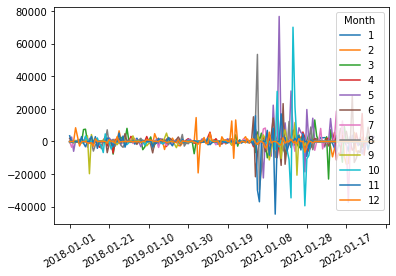

In [67]:
#seasonal_pnl.plot(x=seasonal_pnl.index.astype(str))
seasonal_pnl.set_index(seasonal_pnl.index.astype('str')).plot(rot=30)

In [70]:
#metrics.holdings, metrics.returns
# res = metrics.seasonal_pnl()
res_df = metrics.lead_lag()
print(res_df)

{'leadlag_sharpes':                               -20       -19       -18       -17       -16  \
fullsample              -0.101472  0.678731  0.053587 -0.384331 -0.329737   
1980-Jan-01:1989-Dec-31       NaN       NaN       NaN       NaN       NaN   
1990-Jan-01:1999-Dec-31       NaN       NaN       NaN       NaN       NaN   
2000-Jan-01:2009-Dec-31       NaN       NaN       NaN       NaN       NaN   
2010-Jan-01:2019-Dec-31 -1.265236  0.226739 -1.693957 -0.744997  0.093792   
2020-Jan-01:2029-Dec-31  0.193918  0.886653  0.589510 -0.366261 -0.475561   

                              -15       -14       -13       -12       -11  \
fullsample               0.125264 -0.893150 -1.358266 -1.498786 -1.257345   
1980-Jan-01:1989-Dec-31       NaN       NaN       NaN       NaN       NaN   
1990-Jan-01:1999-Dec-31       NaN       NaN       NaN       NaN       NaN   
2000-Jan-01:2009-Dec-31       NaN       NaN       NaN       NaN       NaN   
2010-Jan-01:2019-Dec-31  0.541375 -0.377697 -1.774671  

[Text(0.0, 0, '-20.0'),
 Text(5.0, 0, '-15.0'),
 Text(10.0, 0, '-10.0'),
 Text(15.0, 0, '-5.0'),
 Text(20.0, 0, '0.0'),
 Text(25.0, 0, '5.0'),
 Text(30.0, 0, '10.0'),
 Text(35.0, 0, '15.0'),
 Text(40.0, 0, '20.0'),
 Text(45.0, 0, '25.0'),
 Text(50.0, 0, '30.0'),
 Text(55.0, 0, '35.0'),
 Text(60.0, 0, '40.0'),
 Text(65.0, 0, '45.0'),
 Text(70.0, 0, '50.0'),
 Text(75.0, 0, '55.0'),
 Text(80.0, 0, '60.0')]

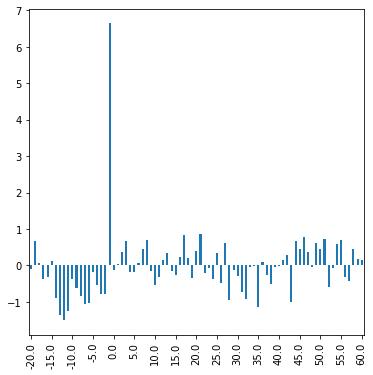

In [90]:
ts = res_df['leadlag_sharpes'].loc['fullsample']
ax = ts.plot(kind='bar',figsize=(6, 6))
new_ticks = np.linspace(-20, 60, 17)
ax.set_xticks(np.interp(new_ticks, ts.index, np.arange(ts.size)))
ax.set_xticklabels(new_ticks)


                 1         2         5         10        20
sharpe     0.041510  0.371497 -0.178377 -0.545299  0.387321
sharpe_fh -0.097464  0.536867 -0.831639  1.740377  0.654060
sharpe_sh  0.072639  0.405681 -0.021329 -1.466374  0.335217


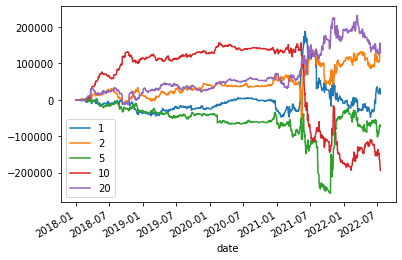

In [92]:
res = metrics.lagged_pnl(lags=[1,2,5,10,20])
res['cumpnl'].plot()
print(res['sharpe'])

                 1         2         5         10        20
sharpe     0.053036  0.225302  0.391806  0.432316  0.410546
sharpe_fh -0.394823 -0.291161 -0.175889 -0.103782 -0.037417
sharpe_sh  0.169686  0.388013  0.596382  0.641867  0.600427


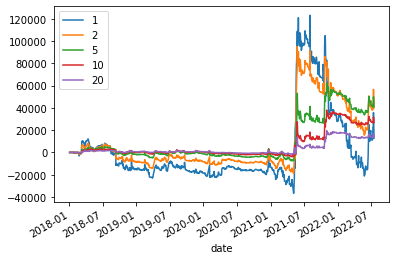

In [93]:
res = metrics.smoothed_pnl(smooth_hls=[1, 2, 5, 10, 20])
res['cumpnl'].plot()
print(res['sharpe'])


<AxesSubplot:xlabel='date'>

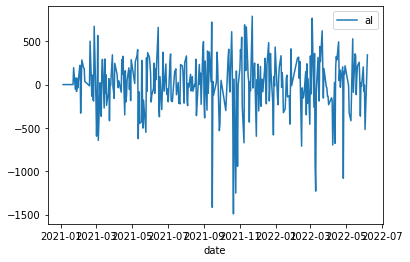

In [10]:
nb_df['holding'].to_frame('al').plot()

In [36]:
pd.to_datetime('2021-01-04').replace(day=1)

Timestamp('2021-01-01 00:00:00')

In [31]:
calendar_aggregation(nb_df, period = 'weekly', how = 'sum')

,open,high,low,close,volume,openInterest,month,price_chg,shift
date,,,,,,,,,
2021-01-08,1483.9,1543.1,1466.6,1524.9,281968,176433,15,18.9,-133.0
2021-01-15,1585.5,1616.8,1546.3,1575.8,550308,221988,15,-5.2,-133.0
2021-01-22,1554.8,1574.7,1529.9,1549.3,631411,232034,15,-7.1,-133.0
2021-01-29,1524.2,1550.3,1511.0,1528.8,107088,123896,20,2.3,-161.5
2021-02-05,1597.3,1628.2,1577.5,1614.2,187718,167511,20,24.0,-161.5
...,...,...,...,...,...,...,...,...,...
2022-05-06,1396.5,1413.7,1373.4,1395.9,73601,35847,14,24.8,0.0
2022-05-13,3406.1,3482.3,3323.5,3400.3,359275,112629,35,-2.3,0.0
2022-05-20,3514.8,3588.4,3446.9,3519.5,842207,160928,35,0.8,0.0


In [4]:
start_date = datetime.date(2014,1,1)
end_date = datetime.date(2022,6,17)

nb_df = dataseries.nearby('al', 1, start_date = start_date, end_date = end_date, roll_rule='-30b',shift_mode=1)
#nb1_df = dataseries.nearby('sc', 2, start_date = start_date, end_date = end_date, roll_rule='-20b',shift_mode=1)
#nb2_df = nearby('al', 2, start_date = start_date, end_date = end_date, roll_rule='-30b',shift_mode=2)
print(nb_df)

           contract     open     high      low    close  volume  openInterest  \
date                                                                            
2014-01-06   al1403  13625.0  13645.0  13550.0  13550.0    7706         49150   
2014-01-07   al1403  13555.0  13575.0  13545.0  13550.0    4834         48892   
2014-01-08   al1403  13550.0  13575.0  13480.0  13505.0    4134         48702   
2014-01-09   al1403  13505.0  13530.0  13440.0  13440.0    5276         48812   
2014-01-10   al1403  13440.0  13450.0  13395.0  13405.0    7156         47574   
...             ...      ...      ...      ...      ...     ...           ...   
2022-06-13   al2208  20450.0  20530.0  19935.0  20010.0  118856        104803   
2022-06-14   al2208  19845.0  20125.0  19840.0  20015.0   88304        109073   
2022-06-15   al2208  19950.0  20180.0  19730.0  19815.0  102628        113882   
2022-06-16   al2208  19850.0  20235.0  19850.0  19990.0  102326        119692   
2022-06-17   al2208  19700.0

In [11]:
print(load_fut_by_product('eg', 'DCE', datetime.date(2022,5,20) ,datetime.date(2022,5,20)))
#print(load_fut_by_product('sc', 'INE', datetime.date(2022,3,2) ,datetime.date(2022,3,2)))

    instID        date    open    high     low   close  volume  openInterest
0   eg2206  2022-05-20  4916.0  4964.0  4829.0  4829.0     811         12841
1   eg2207  2022-05-20  4958.0  5012.0  4876.0  4893.0   50266         76150
2   eg2208  2022-05-20  4997.0  5050.0  4914.0  4932.0   24505         45958
3   eg2209  2022-05-20  5039.0  5080.0  4950.0  4956.0  431737        286305
4   eg2210  2022-05-20  5055.0  5100.0  4975.0  4975.0   10219         28978
5   eg2211  2022-05-20  5056.0  5119.0  4993.0  4993.0    6682         12155
6   eg2212  2022-05-20  5148.0  5148.0  5148.0  5148.0       0             8
7   eg2301  2022-05-20  5116.0  5156.0  5034.0  5042.0     451          1724
8   eg2302  2022-05-20  5226.0  5226.0  5226.0  5226.0       0             7
9   eg2303  2022-05-20  5104.0  5104.0  5104.0  5104.0       0             1
10  eg2304  2022-05-20  5050.0  5050.0  5050.0  5050.0       0             1


In [7]:
#nb_df[nb1_df['instID'] == nb_df['instID']]
#nb_df.close.plot(color='r')

#nb1_df.close.plot(color='y')
print(nb1_df.close.diff().max(), nb1_df.price_chg.max())
#nb_df[['close']].plot()
#flag = nb1_df.close.diff()>1.0
#nb1_df[flag | flag.shift(-1)]
#nb1_df.loc[datetime.date(2018,9,8):datetime.date(2018,9,20):]

NameError: name 'nb1_df' is not defined

In [2]:
start_date = datetime.date(2011,1,1)
end_date = datetime.date(2022, 1, 28)
prodcode = 'ZC'
roll_rule = '-30b'
shift_mode = 1
n = 1

adj_field = 'close'
calc_fields = ['open', 'close', 'high', 'low']
contract_filter = [1, 5, 9]

exch = misc.prod2exch(prodcode)
xdf = load_fut_by_product(prodcode, exch, start_date ,end_date)
xdf['expiry'] = xdf['instID'].apply(lambda x: misc.contract_expiry(x, hols = misc.CHN_Holidays))
xdf['month'] = xdf['instID'].apply(lambda x: misc.inst2contmth(x)%100)
xdf = xdf.sort_values(['instID', 'date'])

if shift_mode == 2:
    xdf['price_chg'] = np.log(xdf[adj_field]).diff()
else:
    xdf['price_chg'] = xdf[adj_field].diff()        
xdf.loc[xdf['instID']!=xdf['instID'].shift(1), 'price_chg'] = 0
if (roll_rule[0] == '-') and (roll_rule[-1] in ['b', 'd']):
    xdf['roll_date'] = xdf['expiry'].apply(lambda x: misc.day_shift(x, roll_rule, hols = misc.CHN_Holidays))
    xdf = xdf[xdf.date <= xdf['roll_date']]
else:
    xdf['roll_date'] = xdf['expiry']
if contract_filter:
    xdf = xdf[xdf.month.isin(contract_filter)]
df = pd.pivot_table(xdf, index = 'date', columns = 'expiry', values = 'instID', aggfunc = 'first')
df1 = df.apply(lambda x: pd.Series(x.dropna().values), axis=1)
df1 = df1.reset_index()

col_df = df1[['date', n-1]].rename(columns = {n-1: 'instID'})
#if len(col_df[col_df['instID'].isna()])> 0:
#    raise ValueError('There are nan values for product=%s, nearby=%s, roll=%s' % (prodcode, str(n), roll_rule))
col_df = col_df.fillna(method = 'ffill')
out_df = pd.merge(col_df, xdf,left_on = ['date', 'instID'], right_on=['date', 'instID'], how = 'left')

if shift_mode > 0:
    cum_adj = out_df.loc[::-1, 'price_chg'].cumsum().shift(1).fillna(0)[::-1]
    if shift_mode == 2:
        adj_price = out_df[adj_field].iloc[-1]/np.exp(cum_adj)
        out_df['shift'] = np.log(adj_price) - np.log(out_df[adj_field])
    else:
        adj_price = out_df[adj_field].iloc[-1] - cum_adj
        out_df['shift'] = adj_price - out_df[adj_field]    

    for cfield in calc_fields:
        if shift_mode == 2:
            out_df[cfield] = out_df[cfield] * np.exp(out_df['shift'])
        else:
            out_df[cfield] = out_df[cfield] + out_df['shift']
else:
    out_df['shift'] = 0
out_df = out_df.set_index('date')

In [6]:
load_fut_by_product('TA', 'CZCE', start_date ,end_date)

,instID,date,open,high,low,close,volume,openInterest
0,TA1101,2011-01-04,9986.0,10194.0,9948.0,10172.0,1826,26168
1,TA1102,2011-01-04,10152.0,10152.0,10152.0,10152.0,6,230
2,TA1103,2011-01-04,10340.0,10412.0,10320.0,10398.0,28,274
3,TA1104,2011-01-04,10498.0,10522.0,10344.0,10522.0,6,212
4,TA1105,2011-01-04,10430.0,10620.0,10372.0,10592.0,446228,225166
...,...,...,...,...,...,...,...,...
23472,TA209,2022-01-28,5516.0,5570.0,5446.0,5480.0,51837,142881
23473,TA210,2022-01-28,5572.0,5606.0,5506.0,5506.0,46,4695
23474,TA211,2022-01-28,5586.0,5616.0,5514.0,5538.0,36,2882
23475,TA212,2022-01-28,5602.0,5620.0,5590.0,5592.0,7,2519


In [144]:
#out_df[out_df.instID.isna()]

#out_df.loc[datetime.date(2017,11,20):datetime.date(2017,12,10),:]
#out_df.close.plot()
print(out_df.close.diff().max(),out_df.price_chg.max())

1.2449999999999903 1.2449999999999903


In [5]:
price_adj = out_df.loc[::-1, 'price_chg'].cumsum().shift(1).fillna(0)[::-1]
price_close = out_df['close'].iloc[-1] - price_adj
price_shift = price_close - out_df['close']
print(price_close, price_shift)

0      12365.0
1      12360.0
2      12380.0
3      12380.0
4      12435.0
        ...   
500    21025.0
501    21055.0
502    21525.0
503    21540.0
504    21950.0
Name: price_chg, Length: 505, dtype: float64 0     -1725.0
1     -1725.0
2     -1725.0
3     -1645.0
4     -1645.0
        ...  
500       0.0
501       0.0
502       0.0
503       0.0
504       0.0
Length: 505, dtype: float64


In [55]:
xdf = xdf.sort_values(['instID', 'date'])
xdf['chg'] = xdf['close'].diff()
flag = xdf['instID']!=xdf['instID'].shift(1)
xdf.loc[flag, 'chg'] = 0
print(xdf)

      instID        date     open     high      low    close  volume  \
0     al2001  2020-01-02  14355.0  14425.0  14355.0  14410.0    5391   
12    al2001  2020-01-03  14390.0  14425.0  14375.0  14410.0    8795   
24    al2001  2020-01-06  14425.0  14460.0  14390.0  14415.0    6025   
36    al2001  2020-01-07  14410.0  14420.0  14300.0  14300.0   10600   
48    al2001  2020-01-08  14260.0  14405.0  14260.0  14400.0    5570   
...      ...         ...      ...      ...      ...      ...     ...   
5967  al2301  2022-01-24  21140.0  21180.0  20840.0  20845.0      16   
5979  al2301  2022-01-25  20935.0  20940.0  20845.0  20850.0      31   
5991  al2301  2022-01-26  21220.0  21415.0  21145.0  21395.0      62   
6003  al2301  2022-01-27  21310.0  21395.0  21295.0  21395.0       3   
6015  al2301  2022-01-28  21365.0  21600.0  21340.0  21600.0      29   

      openInterest      expiry   roll_date    chg  
0            45835  2020-01-15  2019-12-04    0.0  
12           41670  2020-01-15 

In [4]:
adf = df.iloc[:, df.columns.get_level_values(0)=='close']
nb_df = nearby(adf, roll = 30)
print(nb_df[0])

close                                                         \
expiry     2021-01-15 2021-02-15 2021-03-15 2021-04-15 2021-05-17 2021-06-15   
date                                                                           
2021-01-04    15615.0    15430.0    15330.0    15290.0    15250.0    15205.0   
2021-01-05    15575.0    15370.0    15310.0    15290.0    15270.0    15220.0   
2021-01-06    15585.0    15400.0    15380.0    15390.0    15380.0    15335.0   
2021-01-07    15530.0    15320.0    15315.0    15325.0    15305.0    15280.0   
2021-01-08    15530.0    15340.0    15290.0    15300.0    15290.0    15215.0   
...               ...        ...        ...        ...        ...        ...   
2022-01-24        NaN        NaN        NaN        NaN        NaN        NaN   
2022-01-25        NaN        NaN        NaN        NaN        NaN        NaN   
2022-01-26        NaN        NaN        NaN        NaN        NaN        NaN   
2022-01-27        NaN        NaN        NaN        NaN        NaN        NaN   
2022-01-28        NaN        NaN        NaN        NaN        NaN        NaN   

                                                        ...             \
expiry     2021-07-15 2021-08-16 2021-09-15 2021-10-15  ... 2022-04-15   
date                                                    ...              
2021-01-04    15190.0    15165.0    15160.0    15095.0  ...        NaN   
2021-01-05    15190.0    15110.0    15105.0    15080.0  ...        NaN   
2021-01-06    15305.0    15275.0    15250.0    15230.0  ...        NaN   
2021-01-07    15245.0    15200.0    15260.0    15180.0  ...        NaN   
2021-01-08    15170.0    15160.0    15145.0    15075.0  ...        NaN   
...               ...        ...        ...        ...  ...        ...   
2022-01-24        NaN        NaN        NaN        NaN  ...    21025.0   
2022-01-25        NaN        NaN        NaN        NaN  ...    21055.0   
2022-01-26        NaN        NaN        NaN        NaN  ...    21525.0   
2022-01-27        NaN        NaN        NaN        NaN  ...    21540.0   
2022-01-28        NaN        NaN        NaN        NaN  ...    21895.0   

                                                                              \
expiry     2022-05-16 2022-06-15 2022-07-15 2022-08-15 2022-09-15 2022-10-17   
date                                                                           
2021-01-04        NaN        NaN        NaN        NaN        NaN        NaN   
2021-01-05        NaN        NaN        NaN        NaN        NaN        NaN   
2021-01-06        NaN        NaN        NaN        NaN        NaN        NaN   
2021-01-07        NaN        NaN        NaN        NaN        NaN        NaN   
2021-01-08        NaN        NaN        NaN        NaN        NaN        NaN   
...               ...        ...        ...        ...        ...        ...   
2022-01-24    21000.0    20980.0    20930.0    20940.0    20990.0    20885.0   
2022-01-25    21045.0    21025.0    21010.0    21010.0    21015.0    21135.0   
2022-01-26    21495.0    21475.0    21445.0    21485.0    21425.0    21460.0   
2022-01-27    21525.0    21505.0    21465.0    21445.0    21435.0    21410.0   
2022-01-28    21820.0    21780.0    21735.0    21685.0    21670.0    21660.0   

                                             
expiry     2022-11-15 2022-12-15 2023-01-16  
date                                         
2021-01-04        NaN        NaN        NaN  
2021-01-05        NaN        NaN        NaN  
2021-01-06        NaN        NaN        NaN  
2021-01-07        NaN        NaN        NaN  
2021-01-08        NaN        NaN        NaN  
...               ...        ...        ...  
2022-01-24    20830.0    20770.0    20845.0  
2022-01-25    20990.0    20910.0    20850.0  
2022-01-26    21440.0    21430.0    21395.0  
2022-01-27    21400.0    21460.0    21395.0  
2022-01-28    21710.0    21620.0    21600.0  

[262 rows x 25 columns]

In [6]:
def nearby(prodcode, n = 1, start_date = None, end_date = None, 
           roll_rule = '-20b', shift_mode = 0, 
           adj_field = 'close', calc_fields = ['open', 'close', 'high', 'low'], 
           contract_filter = None, fill_cont = False,
          ):
    exch = misc.prod2exch(prodcode)
    xdf = load_fut_by_product(prodcode, exch, start_date ,end_date)
    xdf['expiry'] = xdf['instID'].apply(lambda x: misc.contract_expiry(x, hols = misc.CHN_Holidays))
    xdf['month'] = xdf['instID'].apply(lambda x: misc.inst2contmth(x)%100)
    xdf = xdf.sort_values(['instID', 'date'])

    if shift_mode == 2:
        xdf['price_chg'] = np.log(xdf[adj_field]).diff()
    else:
        xdf['price_chg'] = xdf[adj_field].diff()        
    xdf.loc[xdf['instID']!=xdf['instID'].shift(1), 'price_chg'] = 0
    if (roll_rule[0] == '-') and (roll_rule[-1] in ['b', 'd']):
        xdf['roll_date'] = xdf['expiry'].apply(lambda x: misc.day_shift(x, roll_rule, hols = misc.CHN_Holidays))
        xdf = xdf[xdf.date <= xdf['roll_date']]
    else:
        xdf['roll_date'] = xdf['expiry']
    if contract_filter:
        xdf = xdf[xdf.month.isin(contract_filter)]
    df = pd.pivot_table(xdf, index = 'date', columns = 'expiry', values = 'instID', aggfunc = 'first')
    df1 = df.apply(lambda x: pd.Series(x.dropna().values), axis=1)
    df1 = df1.reset_index()
    col_df = df1[['date', n-1]].rename(columns = {n-1: 'instID'})
    if len(col_df[col_df['instID'].isna()])> 0:
        if fill_cont:
            col_df = col_df.fillna(method = 'ffill')
        else:
            raise ValueError('There are nan values for product=%s, nearby=%s, roll=%s' % (prodcode, str(n), roll_rule))
    out_df = pd.merge(col_df, xdf,left_on = ['date', 'instID'], right_on=['date', 'instID'], how = 'left')
    if shift_mode > 0:
        cum_adj = out_df.loc[::-1, 'price_chg'].cumsum().shift(1).fillna(0)[::-1]
        if shift_mode == 2:
            adj_price = out_df[adj_field].iloc[-1]/np.exp(cum_adj)
            out_df['shift'] = np.log(adj_price) - np.log(out_df[adj_field])
        else:
            adj_price = out_df[adj_field].iloc[-1] - cum_adj
            out_df['shift'] = adj_price - out_df[adj_field]    

        for cfield in calc_fields:
            if shift_mode == 2:
                out_df[cfield] = out_df[cfield] * np.exp(out_df['shift'])
            else:
                out_df[cfield] = out_df[cfield] + out_df['shift']
    else:
        out_df['shift'] = 0
    out_df = out_df.set_index('date')
    return out_df

,instID,date,open,high,low,close,volume,openInterest
0,ME1203,2011-10-28,3199.0,3220.0,3130.0,3139.0,40508,3342
1,ME1204,2011-10-28,3150.0,3209.0,3143.0,3148.0,102,44
2,ME1205,2011-10-28,3192.0,3233.0,3172.0,3182.0,3024,424
3,ME1206,2011-10-28,3258.0,3258.0,3195.0,3195.0,4,2
4,ME1209,2011-10-28,3195.0,3263.0,3189.0,3198.0,108,62
...,...,...,...,...,...,...,...,...
14173,MA209,2022-01-28,2805.0,2895.0,2780.0,2794.0,15715,56821
14174,MA210,2022-01-28,2860.0,2902.0,2801.0,2801.0,1521,7209
14175,MA211,2022-01-28,2863.0,2901.0,2793.0,2814.0,17,14448
14176,MA212,2022-01-28,2889.0,2930.0,2832.0,2832.0,15,4949


In [10]:
df = pd.read_csv('C:\\dev\\pyktrader3\\process\\option_test\\volgrids_IO_220715.csv', header=None)
df